In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Set option max columns display
pd.options.display.max_rows = 150
pd.options.display.max_columns = 150

data = pd.read_csv('E:/TT/TRAIN (1).csv')
data_valid = pd.read_csv('E:/TT/loan.csv/VALID.csv')

C:\Users\chung\AppData\Local\Temp\ipykernel_8796\4284343568.py:8: DtypeWarning: Columns (20,56,113,124,125,126,129,130,131,134,140,141,142) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('E:/TT/TRAIN (1).csv')
C:\Users\chung\AppData\Local\Temp\ipykernel_8796\4284343568.py:9: DtypeWarning: Columns (19,112,123,124,125,128,129,130,133) have mixed types. Specify dtype option on import or set low_memory=False.
  data_valid = pd.read_csv('E:/TT/loan.csv/VALID.csv')


data

In [3]:
d0 = data[['id', 'GOOD']]

In [6]:
d = d0.groupby('id', as_index=True, dropna = False).agg(["count", "sum"])
d

GOOD        
      count     sum
id                 
NaN  294507  225927

In [2]:
from itertools import combinations

def get_index(format_lists, name):
    N = len(format_lists)
    for i in range(N):
        if format_lists[i]['name'] == name:
            return i
    return -1

def create_groupData(data_train, data_valid, target, num_bins = 20, format_lists = None):
    GRP_data_train = pd.DataFrame()
    GRP_data_valid = pd.DataFrame()
    col_names = data_train.columns
    for var_name in col_names[~col_names.isin([target])]:
        if data_train[var_name].dtype.kind in 'bifc':
            check = get_index(format_lists, var_name)
            temp_train = data_train[var_name]
            temp_valid = data_valid[var_name]
            if check != -1:
                format_temp = format_lists[check]
                if 'missing' in format_temp:
                    filtered_data = temp_train[(temp_train > format_temp['missing'][0]) & (temp_train <= format_temp['missing'][1])]
                    mean_in_range = filtered_data.mean()
                    temp_train = temp_train.fillna(mean_in_range)
                    temp_valid = temp_valid.fillna(mean_in_range)

                GRP_data_train[var_name] = pd.cut(temp_train, bins = format_temp['bins'])
                GRP_data_valid[var_name] = pd.cut(temp_valid, bins = format_temp['bins'])
            else:
                bin_edges = pd.qcut(temp_train, q=num_bins, retbins=True, duplicates='drop')[1]
                bin_edges[0] = -np.inf
                bin_edges[-1] = np.inf

                GRP_data_train[var_name] = pd.cut(temp_train, bins = bin_edges)
                GRP_data_valid[var_name] = pd.cut(temp_valid, bins=bin_edges)

        else:
            check = get_index(format_lists, var_name)
            temp_train = data_train[var_name]
            temp_valid = data_valid[var_name]
            if check != -1:
                format_temp = format_lists[check]
                if 'missing' in format_temp:
                    GRP_data_train[var_name] = temp_train.map(format_temp['bins']).fillna(format_temp['missing'])
                    GRP_data_valid[var_name] = temp_valid.map(format_temp['bins']).fillna(format_temp['missing'])
                else:
                    GRP_data_train[var_name] = temp_train.map(format_temp['bins'])
                    GRP_data_valid[var_name] = temp_valid.map(format_temp['bins'])
            else:
                GRP_data_train[var_name] = temp_train
                GRP_data_valid[var_name] = temp_valid
        # GRP_data = GRP_data.astype(str)
    GRP_data_train[target] = data_train[target]
    GRP_data_valid[target] = data_valid[target]

    return GRP_data_train, GRP_data_valid


def iv_woe(data, target):
    cols = data.columns
    iv = pd.DataFrame()
    woe = []
    NN = len(data)
    for ivars in cols[~cols.isin([target])]:
        d0 = data[[ivars, target]]
        d = d0.groupby(ivars, as_index=True, dropna = False).agg(["count", "sum"])
        d.columns = ['N', 'Events']
        d['Percent'] = (d['N']/NN)*100
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['Bad rate'] = d['Non-Events']/d['N']
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        iv=pd.concat([iv,temp], axis=0)
        woe.append(d)
    return iv.set_index('Variable'), woe

# truyen vao group data
def iv_woe_cross(data, target, data_woe = None):
    cols = data.columns
    cols = [x for x in cols if x != target]
    iv = pd.DataFrame()
    woe = []
    NN = len(data)
    for combination in combinations(cols,2):
        jvars, ivars = combination[0], combination[1]
        d0 = data[[jvars,ivars, target]]
        if not data_woe.empty:
            d1 = data_woe[[jvars, ivars]]
        d = d0.groupby([jvars, ivars], as_index=False, dropna = False).agg(["count", "sum"])
        d.columns = ['N', 'Events']
        d['Percent'] = (d['N']/NN)*100
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['Bad rate'] = d['Non-Events']/d['N']
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV cross'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        if not data_woe.empty:
            try:
                m = d1[jvars].corr(d1[ivars])
            except:
                m = -999
            temp =pd.DataFrame({"Variable 1" : [jvars], 'Variable 2' : [ivars], "IV cross" : [d['IV cross'].sum()], 'Correlation': [m]}, columns = ["Variable 1",'Variable 2', "IV cross", 'Correlation'])
        else:
            temp =pd.DataFrame({"Variable 1" : [jvars], 'Variable 2' : [ivars], "IV cross" : [d['IV cross'].sum()]}, columns = ["Variable 1",'Variable 2', "IV cross"])
        iv=pd.concat([iv,temp])
        woe.append(d)
    iv = iv.reset_index(drop=True)
    return iv, woe

# truyen vao group data
def create_woe_data(data_train, data_valid, target):
    data_train = data_train.astype(str)
    data_train[target] = data_train[target].astype(int)
    data_valid = data_valid.astype(str)
    data_valid[target] = data_valid[target].astype(int)
    NN = len(data_train)
    woe_data_train = pd.DataFrame()
    woe_data_valid = pd.DataFrame()
    col_names = data_train.columns
    for ivars in col_names[~col_names.isin([target])]:
        d0 = data_train[[ivars, target]]
        d = d0.groupby(ivars, as_index=True, dropna = False).agg(["count", "sum"])
        d.columns = ['N', 'Events']
        d['Percent'] = (d['N']/NN)*100
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['Bad Rate'] = d['Non-Events']/d['N']
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        woe_mapping = d['WoE'].to_dict()
        woe_data_train[ivars] = data_train[ivars].map(woe_mapping)
        woe_data_valid[ivars] = data_valid[ivars].map(woe_mapping)
    woe_data_train[target] = data_train[target]
    woe_data_valid[target] = data_valid[target]
    return woe_data_train, woe_data_valid

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

def gini(train_woe, valid_woe, target):
    X_train = train_woe.drop([target], axis = 1)
    y_train = train_woe[target]

    X_test = valid_woe.drop([target], axis = 1)
    y_test = valid_woe[target]

    log_reg = LogisticRegression(random_state=42, max_iter=1000)
    log_reg.fit(X_train,y_train)
    try:
        y_pred_valid = log_reg.predict_proba(X_test)
        gini_valid = 2*roc_auc_score(y_test, y_pred_valid[:,1] )-1
    except:
        gini_valid = -np.inf
        print(train_woe.columns)
    y_pred_train = log_reg.predict_proba(X_train)
    gini_train = 2*roc_auc_score(y_train, y_pred_train[:,1] )-1

    return gini_train, gini_valid

# truyen vao group data
def cross_table(data_train, data_valid, target):
    data_train_woe, data_valid_woe = create_woe_data(data_train, data_valid, target)
    cols = data_train.columns
    cols = [x for x in cols if x != target]
    iv = pd.DataFrame()
    woe = []
    NN = len(data)
    a, b = iv_woe(data_train, target)
    for combination in combinations(cols,2):
        # a, b = iv_woe(data_train, target)
        jvars, ivars = combination[0], combination[1]
        d0 = data_train[[jvars,ivars, target]]
        d = d0.groupby([jvars, ivars], as_index=False, dropna = False).agg(["count", "sum"])
        d.columns = ['N', 'Events']
        d['Percent'] = (d['N']/NN)*100
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV cross'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        woe.append(d)
        cross_train, cross_valid = pd.DataFrame(), pd.DataFrame()
        cross_train[jvars +' '+ ivars] = data_train[jvars].astype(str) + ' ' + data_train[ivars].astype(str)
        cross_train[target] = data_train[target]
        cross_valid[jvars +' '+ ivars] = data_valid[jvars].astype(str) + ' ' + data_valid[ivars].astype(str)
        cross_valid[target] = data_valid[target]

        cross_train_woe, cross_valid_woe = create_woe_data(cross_train, cross_valid, target)

        gini_cross_train, gini_cross_valid = gini(cross_train_woe, cross_valid_woe, target)

        j_var_train = data_train_woe[[jvars, target]]
        i_var_train = data_train_woe[[ivars, target]]
        j_var_valid = data_valid_woe[[jvars, target]]
        i_var_test = data_valid_woe[[ivars, target]]


        gini_jvar_train, gini_jvar_valid = gini(j_var_train, j_var_valid, target)
        gini_ivar_train, gini_ivar_valid = gini(i_var_train, i_var_test, target)


        temp =pd.DataFrame({"Variable 1" : [jvars], 'Variable 2' : [ivars], "IV cross" : [d['IV cross'].sum()], 'gini_cross_train': [gini_cross_train], 'gini_cross_valid': [gini_cross_valid], 'gini_Variable_1_Train':[gini_jvar_train], 'gini_Variable_1_Valid': [gini_jvar_valid], 'gini_Variable_2_Train':[gini_ivar_train], 'gini_Variable_2_Valid': [gini_ivar_valid]}, columns = ["Variable 1",'Variable 2', "IV cross", "gini_cross_train", "gini_cross_valid", "gini_Variable_1_Train", "gini_Variable_1_Valid", "gini_Variable_2_Train", "gini_Variable_2_Valid"])
        iv=pd.concat([iv,temp])
    iv = iv.reset_index(drop=True)
    mapp = a['IV'].to_dict()
    iv['IV Variable 1'] = iv['Variable 1'].map(mapp)
    iv['IV Variable 2'] = iv['Variable 2'].map(mapp)
    return iv, woe

In [3]:

import datetime
import numpy as np

def convert_to_months_and_home_owened(data):
    data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])
    data['issue_d'] = pd.to_datetime(data['issue_d'])
    data['last_credit_pull_d'] = pd.to_datetime(data['last_credit_pull_d'])
    today = datetime.datetime.today()
    # data['earliest_cr_line_months_to_today'] = (today - data['earliest_cr_line']).dt.days // 30
    data['earliest_cr_line_months_to_issue_date'] = (data['issue_d'] - data['earliest_cr_line']).dt.days // 30
    data['issue_d_to_last_credit_pull_d'] = (data['last_credit_pull_d'] - data['issue_d']).dt.days // 30
    map = {'MORTGAGE': 'MORTGAGE', 'RENT': 'RENT', 'OWN': 'OWN', 'ANY': 'RENT', 'NONE': 'RENT'}
    data['home_ownership'] = data['home_ownership'].map(map)
    data['issue_d_to_last_credit_pull_d'] = data['issue_d_to_last_credit_pull_d'].fillna(0)
    data['issue_d_to_last_credit_pull_d'] = data['issue_d_to_last_credit_pull_d'].apply(lambda x: max(x, 0))
    data['last_credit_pull_d_to_today'] = (today - data['last_credit_pull_d']).dt.days // 30

    return data

data = convert_to_months_and_home_owened(data)
data_validd = convert_to_months_and_home_owened(data_valid)



In [4]:
#format_list
loan_amnt= {'name': 'loan_amnt','bins': [-np.inf, 3000,10000, 15000, np.inf]}
grade = {'name': 'grade', 'bins': {'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D', 'E': 'E','F': 'F and G', 'G': 'F and G'}}
total_bc_limit = {'name': 'total_bc_limit', 'bins': [-np.inf, 10000, 18000, 30000, 50000, np.inf]}
annual_inc = {'name': 'annual_inc', 'bins': [-np.inf, 40000, 50000, 65000, 80000, 100000, np.inf]}
mort_acc = {'name': 'mort_acc', 'bins': [-np.inf, 0,3,np.inf]}
percent_bc_gt_75 = {'name': 'percent_bc_gt_75', 'bins': [-np.inf, 0, 20, 50, np.inf], 'missing': [20, 50]}
inq_last_6mths = {'name': 'inq_last_6mths', 'bins': [-np.inf, 0, 1, np.inf]}
tot_hi_cred_lim = {'name':'tot_hi_cred_lim', 'bins': [-np.inf, 100000, 150000, 200000, 500000, np.inf]}
num_actv_rev_tl = {'name': 'num_actv_rev_tl', 'bins': [-np.inf, 3, 5, 7, np.inf]}
tot_cur_bal = {'name': 'tot_cur_bal', 'bins':[-np.inf, 20000, 65000, 100000, 160000, 300000, 450000, np.inf]}
# tot_cur_bal = {'name': 'tot_cur_bal', 'bins':[-np.inf, 108000, np.inf]}
revol_bal = {'name': 'revol_bal', 'bins': [-np.inf, 1200, 2400, 6000, 8000, 16000, 18000, 21000, 25000, 43000, np.inf]}
max_bal_bc = {'name': 'max_bal_bc', 'bins': [-np.inf, 250, 1700, 3700, 5000, 7000, 11000, np.inf]}
total_acc = {'name': 'total_acc', 'bins': [-np.inf, 8, 13, 16, 18, 26, np.inf]}
num_il_tl = {'name': 'num_il_tl', 'bins': [-np.inf, 1, 2, 4, 6, 24, np.inf]}
num_rev_accts = {'name': 'num_rev_accts', 'bins': [-np.inf, 4, 5, 6, 9, 11, 13, 17, np.inf]}

dti = {'name': 'dti','bins': [-np.inf, 14, 17, 22, 26, 30, np.inf], 'missing': [17, 22]}
revol_util = {'name': 'revol_util','bins': [-np.inf, 18, 30, 45, 57, np.inf], 'missing': [30, 45]}
int_rate = {'name': 'int_rate','bins': [-np.inf, 8, 11, 13, 15, 18, np.inf]}

issue_d_to_last_credit_pull_d = {'name': 'issue_d_to_last_credit_pull_d', 'bins': [-np.inf,4, 7,20, 32,np.inf]}
installment = {'name': 'installment', 'bins': [-np.inf, 100, 200, 300, np.inf]}
open_rv_24m = {'name': 'open_rv_24m', 'bins': [-np.inf, 1, 2, 4, np.inf]}
all_util = {'name': 'all_util', 'bins': [-np.inf, 35, 47, 64, np.inf], 'missing': [47, 64]}
total_rev_hi_lim = {'name': 'total_rev_hi_lim', 'bins': [-np.inf, 30000, 37000, 48000, 68000, np.inf]}
acc_open_past_24mths = {'name': 'acc_open_past_24mths', 'bins': [-np.inf, 3, 5, 8, np.inf]}
avg_cur_bal = {'name': 'avg_cur_bal', 'bins': [-np.inf, 8000, 12000, 27000, np.inf], 'missing': [8000, 12000]}
bc_open_to_buy = {'name': 'bc_open_to_buy', 'bins': [-np.inf, 4200, 10000, 18000, np.inf], 'missing': [4200, 10000]}
bc_util = {'name': 'bc_util', 'bins': [-np.inf, 25, 35, 45, 60, 85, np.inf], 'missing': [45, 60]}
mo_sin_old_rev_tl_op = {'name': 'mo_sin_old_rev_tl_op', 'bins': [-np.inf, 46, 84, 124, 141, np.inf]}
num_rev_tl_bal_gt_0 = {'name': 'num_rev_tl_bal_gt_0', 'bins': [-np.inf, 3, 5, 7, np.inf]}
total_rec_late_fee = {'name': 'total_rec_late_fee', 'bins': [-np.inf, 0, np.inf]}
issue_d_to_last_credit_pull_d = {'name': 'issue_d_to_last_credit_pull_d', 'bins': [-np.inf, 4, 7, np.inf]}
num_bc_sats = {'name': 'num_bc_sats', 'bins': [-np.inf, 1, 2, 4, 6, 11, np.inf]}


In [5]:
format_lists = [loan_amnt, int_rate, installment, grade, annual_inc, dti, acc_open_past_24mths, bc_open_to_buy, bc_util, mort_acc, num_actv_rev_tl, num_rev_tl_bal_gt_0, percent_bc_gt_75, open_rv_24m, all_util, inq_last_6mths, revol_util, total_rev_hi_lim, mo_sin_old_rev_tl_op, tot_hi_cred_lim, total_bc_limit, total_rec_late_fee,issue_d_to_last_credit_pull_d, num_bc_sats, tot_cur_bal]

In [6]:
columns_sequence = "issue_d_to_last_credit_pull_d,total_rec_int,earliest_cr_line_months_to_issue_date,loan_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,emp_length,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_late_fee,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,GOOD"
column_list = columns_sequence.split(',')
column_list = [column.strip() for column in column_list]

train = data[column_list]
valid = data_valid[column_list]
train_grp, valid_grp = create_groupData(data_train = train, data_valid = valid,target = 'GOOD', num_bins= 20, format_lists= format_lists)


In [13]:
train_woe, valid_woe = create_woe_data(train_grp, valid_grp, 'GOOD')
train_woe, valid_woe = train_woe[['grade', 'GOOD']], valid_woe[['grade', 'GOOD']]

In [14]:
target = 'GOOD'
X_train = train_woe.drop([target], axis = 1)
y_train = train_woe[target]

X_test = valid_woe.drop([target], axis = 1)
y_test = valid_woe[target]

log_reg = LogisticRegression(random_state=42, max_iter=1000, fit_intercept=False)
log_reg.fit(X_train,y_train)

LogisticRegression(fit_intercept=False, max_iter=1000, random_state=42)

In [15]:
y_pred_train = log_reg.predict_proba(X_train)

In [16]:
gini_train = 2*roc_auc_score(y_train, y_pred_train[:,1] )-1

In [17]:
gini_train

0.3388633294389538

In [19]:
from sklearn.linear_model import LogisticRegression

In [21]:
neg_log_likelihood = -2 * log_reg.score(X_train, y_train)
print("Negative Log-Likelihood (-2logL):", neg_log_likelihood)

Negative Log-Likelihood (-2logL): -1.1238510459853246


0        -0.147340
1        -0.147340
2         0.437580
3        -0.861234
4         0.437580
            ...   
294502    0.437580
294503   -0.147340
294504   -0.545518
294505   -0.147340
294506    1.349457
Name: grade, Length: 294507, dtype: float64

In [47]:
list2 = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'verification_status', 'annual_inc', 'dti', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'open_rv_24m', 'all_util', 'inq_last_6mths', 'revol_util', 'total_rev_hi_lim', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_bc_limit', 'total_rec_late_fee' ,'GOOD']

In [48]:
list = ['grade', 'tot_hi_cred_lim', 'num_actv_rev_tl', 'loan_amnt', 'dti', 'total_bc_limit', 'verification_status', 'mort_acc', 'term', 'inq_last_6mths', 'percent_bc_gt_75', 'annual_inc', 'total_rec_late_fee', 'GOOD']
gini(train_woe= train_woe[list], valid_woe= valid_woe[list], target= 'GOOD')

(0.47230386537351743, 0.47376524056296176)

In [49]:
list = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'verification_status', 'annual_inc', 'dti', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'open_rv_24m', 'all_util', 'inq_last_6mths', 'revol_util', 'total_rev_hi_lim', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_bc_limit', 'total_rec_late_fee', 'GOOD']
gini(train_woe= train_woe[list], valid_woe= valid_woe[list], target= 'GOOD')


(0.4751489771864166, 0.476583122453365)

In [50]:
list = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'verification_status', 'annual_inc', 'dti', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'open_rv_24m', 'all_util', 'inq_last_6mths', 'revol_util', 'total_rev_hi_lim', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_bc_limit', 'total_rec_late_fee', 'GOOD']


In [110]:
cross_list = [['loan_amnt', 'tot_hi_cred_lim'], ['term', 'bc_open_to_buy'], ['int_rate', 'total_rec_late_fee'], ['installment', 'annual_inc'], ['grade', 'avg_cur_bal'], ['verification_status', 'mort_acc'], ['tot_cur_bal', 'dti'], ['revol_util', 'open_rv_24m'], ['max_bal_bc', 'bc_util'], ['all_util', 'num_actv_rev_tl'], ['num_bc_sats', 'total_bc_limit']]


not_cross_list = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'verification_status', 'annual_inc', 'dti', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'open_rv_24m', 'all_util', 'inq_last_6mths', 'revol_util', 'total_rev_hi_lim', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_bc_limit', 'total_rec_late_fee', 'issue_d_to_last_credit_pull_d', 'max_bal_bc', 'num_bc_sats', 'avg_cur_bal', 'tot_cur_bal']

cross_train = pd.DataFrame()
cross_valid = pd.DataFrame()
for i in cross_list:
    cross_train['Cross_'+ i[0][:3] +'_'+ i[1][:3]] = train_grp[i[0]].astype(str) + '_' + train_grp[i[1]].astype(str)
    cross_valid['Cross_' + i[0][:3] +'_'+ i[1][:3]]= valid_grp[i[0]].astype(str) + '_' + valid_grp[i[1]].astype(str)
    
for j in not_cross_list:
    cross_train[j] = train_grp[j].astype(str)
    cross_valid[j] = valid_grp[j].astype(str)

cross_train['GOOD'] = train_grp['GOOD']
cross_valid['GOOD'] = valid_grp['GOOD']
cross_train_woe, cross_valid_woe = create_woe_data(cross_train, cross_valid, 'GOOD')

In [111]:
cross_train['Cross_num_tot']
cross_train['Cross_tot_dti']

0         (100000.0, 160000.0]_(14.0, 17.0]
1            (20000.0, 65000.0]_(30.0, inf]
2              (-inf, 20000.0]_(-inf, 14.0]
3          (65000.0, 100000.0]_(17.0, 22.0]
4              (-inf, 20000.0]_(-inf, 14.0]
                        ...                
294502    (100000.0, 160000.0]_(14.0, 17.0]
294503    (300000.0, 450000.0]_(17.0, 22.0]
294504     (160000.0, 300000.0]_(30.0, inf]
294505    (160000.0, 300000.0]_(-inf, 14.0]
294506    (300000.0, 450000.0]_(14.0, 17.0]
Name: Cross_tot_dti, Length: 294507, dtype: object

In [112]:
map_cross_num_tot = {'(-inf, 1.0]_(-inf, 10000.0]':'Group 2',
'(-inf, 1.0]_(10000.0, 18000.0]':'Group 1',
'(-inf, 1.0]_(18000.0, 30000.0]':'Group 1',
'(-inf, 1.0]_(30000.0, 50000.0]':'Group 1',
'(-inf, 1.0]_(50000.0, inf]':'Group 1',
'(1.0, 2.0]_(-inf, 10000.0]':'Group 2',
'(1.0, 2.0]_(10000.0, 18000.0]':'Group 2',
'(1.0, 2.0]_(18000.0, 30000.0]':'Group 1',
'(1.0, 2.0]_(30000.0, 50000.0]':'Group 1',
'(1.0, 2.0]_(50000.0, inf]':'Group 1',
'(11.0, inf]_(-inf, 10000.0]':'Group 4',
'(11.0, inf]_(10000.0, 18000.0]':'Group 4',
'(11.0, inf]_(18000.0, 30000.0]':'Group 4',
'(11.0, inf]_(30000.0, 50000.0]':'Group 3',
'(11.0, inf]_(50000.0, inf]':'Group 2',
'(2.0, 4.0]_(-inf, 10000.0]':'Group 3',
'(2.0, 4.0]_(10000.0, 18000.0]':'Group 2',
'(2.0, 4.0]_(18000.0, 30000.0]':'Group 2',
'(2.0, 4.0]_(30000.0, 50000.0]':'Group 1',
'(2.0, 4.0]_(50000.0, inf]':'Group 1',
'(4.0, 6.0]_(-inf, 10000.0]':'Group 4',
'(4.0, 6.0]_(10000.0, 18000.0]':'Group 3',
'(4.0, 6.0]_(18000.0, 30000.0]':'Group 2',
'(4.0, 6.0]_(30000.0, 50000.0]':'Group 1',
'(4.0, 6.0]_(50000.0, inf]':'Group 1',
'(6.0, 11.0]_(-inf, 10000.0]':'Group 4',
'(6.0, 11.0]_(10000.0, 18000.0]':'Group 4',
'(6.0, 11.0]_(18000.0, 30000.0]':'Group 3',
'(6.0, 11.0]_(30000.0, 50000.0]':'Group 2',
'(6.0, 11.0]_(50000.0, inf]':'Group 1'
}


map_cross_tot_dti = {'(-inf, 20000.0]_(-inf, 14.0]':'Group 3',
'(-inf, 20000.0]_(14.0, 17.0]':'Group 4',
'(-inf, 20000.0]_(17.0, 22.0]':'Group 5',
'(-inf, 20000.0]_(22.0, 26.0]':'Group 5',
'(-inf, 20000.0]_(26.0, 30.0]':'Group 6',
'(-inf, 20000.0]_(30.0, inf]':'Group 6',
'(100000.0, 160000.0]_(-inf, 14.0]':'Group 1',
'(100000.0, 160000.0]_(14.0, 17.0]':'Group 2',
'(100000.0, 160000.0]_(17.0, 22.0]':'Group 3',
'(100000.0, 160000.0]_(22.0, 26.0]':'Group 3',
'(100000.0, 160000.0]_(26.0, 30.0]':'Group 4',
'(100000.0, 160000.0]_(30.0, inf]':'Group 5',
'(160000.0, 300000.0]_(-inf, 14.0]':'Group 1',
'(160000.0, 300000.0]_(14.0, 17.0]':'Group 1',
'(160000.0, 300000.0]_(17.0, 22.0]':'Group 2',
'(160000.0, 300000.0]_(22.0, 26.0]':'Group 3',
'(160000.0, 300000.0]_(26.0, 30.0]':'Group 3',
'(160000.0, 300000.0]_(30.0, inf]':'Group 4',
'(20000.0, 65000.0]_(-inf, 14.0]':'Group 3',
'(20000.0, 65000.0]_(14.0, 17.0]':'Group 3',
'(20000.0, 65000.0]_(17.0, 22.0]':'Group 4',
'(20000.0, 65000.0]_(22.0, 26.0]':'Group 5',
'(20000.0, 65000.0]_(26.0, 30.0]':'Group 6',
'(20000.0, 65000.0]_(30.0, inf]':'Group 6',
'(300000.0, 450000.0]_(-inf, 14.0]':'Group 1',
'(300000.0, 450000.0]_(14.0, 17.0]':'Group 1',
'(300000.0, 450000.0]_(17.0, 22.0]':'Group 2',
'(300000.0, 450000.0]_(22.0, 26.0]':'Group 3',
'(300000.0, 450000.0]_(26.0, 30.0]':'Group 3',
'(300000.0, 450000.0]_(30.0, inf]':'Group 3',
'(450000.0, inf]_(-inf, 14.0]':'Group 1',
'(450000.0, inf]_(14.0, 17.0]':'Group 1',
'(450000.0, inf]_(17.0, 22.0]':'Group 1',
'(450000.0, inf]_(22.0, 26.0]':'Group 2',
'(450000.0, inf]_(26.0, 30.0]':'Group 3',
'(450000.0, inf]_(30.0, inf]':'Group 3',
'(65000.0, 100000.0]_(-inf, 14.0]':'Group 2',
'(65000.0, 100000.0]_(14.0, 17.0]':'Group 3',
'(65000.0, 100000.0]_(17.0, 22.0]':'Group 3',
'(65000.0, 100000.0]_(22.0, 26.0]':'Group 4',
'(65000.0, 100000.0]_(26.0, 30.0]':'Group 5',
'(65000.0, 100000.0]_(30.0, inf]':'Group 6'
}

In [113]:
cross_train['C_num_tot'] = cross_train['Cross_num_tot'].map(map_cross_num_tot)
cross_valid['C_num_tot'] = cross_valid['Cross_num_tot'].map(map_cross_num_tot)

cross_train['C_tot_dti'] = cross_train['Cross_tot_dti'].map(map_cross_tot_dti)
cross_valid['C_tot_dti'] = cross_valid['Cross_tot_dti'].map(map_cross_tot_dti)




In [117]:
cross_train_woe, cross_valid_woe = create_woe_data(cross_train, cross_valid, 'GOOD')


In [114]:
iv, woe= iv_woe(cross_train[['C_num_tot', 'C_tot_dti', 'GOOD']], 'GOOD')

In [115]:
iv

,IV
Variable,
C_num_tot,0.082053
C_tot_dti,0.134394


In [116]:
woe[1]

,N,Events,Percent,% of Events,Non-Events,% of Non-Events,Bad rate,WoE,IV
C_tot_dti,,,,,,,,,
Group 1,59584,50949,20.231777,0.225511,8635,0.125911,0.144921,0.582790,0.058046
Group 2,30044,24444,10.201455,0.108194,5600,0.081656,0.186393,0.281407,0.007468
Group 3,109953,85223,37.334596,0.377215,24730,0.360601,0.224914,0.045043,0.000748
Group 4,39571,28722,13.436353,0.127130,10849,0.158195,0.274165,-0.218621,0.006792
Group 5,28806,19738,9.781092,0.087365,9068,0.132225,0.314796,-0.414417,0.018591
Group 6,26549,16851,9.014726,0.074586,9698,0.141411,0.365287,-0.639721,0.042750


In [127]:
model_list = ['loan_amnt', 'grade', 'C_num_tot', 'C_tot_dti', 'term', 'annual_inc', 'verification_status', 'mort_acc', 'num_actv_rev_tl', 'percent_bc_gt_75', 'inq_last_6mths', 'tot_hi_cred_lim', 'total_rec_late_fee', 'GOOD']

len(model_list)

14

In [126]:
gini(cross_train_woe[model_list],cross_valid_woe[model_list], 'GOOD')

(0.47230386537351743, 0.47376524056296176)

In [128]:
gini(cross_train_woe[model_list],cross_valid_woe[model_list], 'GOOD')

(0.4723823344725213, 0.4742212882439596)

In [52]:
ivv, woee = iv_woe(train_grp[['num_bc_sats', 'GOOD']], 'GOOD')

In [160]:
a = ['loan_amnt', 'installment']
b = ['int_rate', 'grade']
c = ['bc_open_to_buy', 'total_bc_limit', 'total_rev_hi_lim']
d = ['open_rv_24m', 'acc_open_past_24mths']
e = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'verification_status', 'annual_inc', 'dti', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'open_rv_24m', 'all_util', 'inq_last_6mths', 'revol_util', 'total_rev_hi_lim', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_bc_limit', 'total_rec_late_fee']

excluded_set = set(a+b+c+d)

a4 = [x for x in e if x not in excluded_set]


In [152]:
cross_train_woe.to_csv('final_train_woe.csv')
cross_valid_woe.to_csv('final_valid_woe.csv')

In [161]:
for a_i in a:
    for b_i in b:
        for c_i in c:
            for d_i in d:
                temp = a4 + [a_i] + [b_i] + [c_i] + [d_i] + ['GOOD'] + ['C_tot_dti'] + ['C_num_tot']
                print(temp)
                print(gini(cross_train_woe[temp], cross_valid_woe[temp], 'GOOD'))

['term', 'verification_status', 'annual_inc', 'dti', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'all_util', 'inq_last_6mths', 'revol_util', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_rec_late_fee', 'loan_amnt', 'int_rate', 'bc_open_to_buy', 'open_rv_24m', 'GOOD', 'C_tot_dti', 'C_num_tot']
(0.4732509789165418, 0.47428000458538033)
['term', 'verification_status', 'annual_inc', 'dti', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'all_util', 'inq_last_6mths', 'revol_util', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_rec_late_fee', 'loan_amnt', 'int_rate', 'bc_open_to_buy', 'acc_open_past_24mths', 'GOOD', 'C_tot_dti', 'C_num_tot']
(0.47297996929749964, 0.4738818650325509)
['term', 'verification_status', 'annual_inc', 'dti', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'all_util', 'inq_last_6mths', 'revol_util', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'tot

In [162]:
for a_i in a:
    for b_i in b:
        for c_i in c:
            for d_i in d:
                temp = a4 + [a_i] + [b_i] + [c_i] + [d_i] + ['GOOD']
                print(temp)
                print(gini(cross_train_woe[temp], cross_valid_woe[temp], 'GOOD'))
                # abs_corr = cross_train_woe[temp].corr().abs()
                # high_corr_values = abs_corr[(abs_corr > 0.7) & (abs_corr != 1)]
                # print(high_corr_values)

['term', 'verification_status', 'annual_inc', 'dti', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'all_util', 'inq_last_6mths', 'revol_util', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_rec_late_fee', 'loan_amnt', 'int_rate', 'bc_open_to_buy', 'open_rv_24m', 'GOOD']
(0.4722112280831896, 0.4733736566738038)
['term', 'verification_status', 'annual_inc', 'dti', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'all_util', 'inq_last_6mths', 'revol_util', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_rec_late_fee', 'loan_amnt', 'int_rate', 'bc_open_to_buy', 'acc_open_past_24mths', 'GOOD']
(0.47189943035290827, 0.4729089955479133)
['term', 'verification_status', 'annual_inc', 'dti', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'all_util', 'inq_last_6mths', 'revol_util', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_rec_late_fee', 'loan_amnt', 'int_rate', 'total_bc_

In [163]:
m = ['term', 'verification_status', 'annual_inc', 'dti', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'all_util', 'inq_last_6mths', 'revol_util', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_rec_late_fee', 'loan_amnt', 'grade', 'total_bc_limit', 'open_rv_24m', 'GOOD']

In [174]:
n = ['term', 'verification_status', 'annual_inc', 'dti', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'all_util', 'inq_last_6mths', 'revol_util', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_rec_late_fee', 'loan_amnt', 'grade', 'bc_open_to_buy', 'open_rv_24m', 'GOOD']

In [176]:
h = ['term', 'verification_status', 'annual_inc', 'dti', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'all_util', 'inq_last_6mths', 'revol_util', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_rec_late_fee', 'loan_amnt', 'grade', 'total_rev_hi_lim', 'open_rv_24m']

In [182]:
iv, woe = iv_woe(train_grp[['total_rec_late_fee', 'GOOD']], 'GOOD')

In [184]:
woe[0]

,N,Events,Percent,% of Events,Non-Events,% of Non-Events,Bad rate,WoE,IV
total_rec_late_fee,,,,,,,,,
"(-inf, 0.0]",280193,221393,95.139674,0.979932,58800,0.857393,0.209855,0.133587,0.016370
"(0.0, inf]",14314,4534,4.860326,0.020068,9780,0.142607,0.683247,-1.960946,0.240292


In [180]:
for i in h:
    print(i)

term
verification_status
annual_inc
dti
bc_util
mort_acc
num_actv_rev_tl
num_rev_tl_bal_gt_0
percent_bc_gt_75
all_util
inq_last_6mths
revol_util
mo_sin_old_rev_tl_op
tot_hi_cred_lim
total_rec_late_fee
loan_amnt
grade
total_rev_hi_lim
open_rv_24m


In [179]:
gini(cross_train_woe[h+["GOOD"]],cross_valid_woe[h+["GOOD"]], 'GOOD')

(0.4740823920285919, 0.47593420276171194)

In [ ]:
for i in n:
    print(i)

In [172]:
gini(cross_train_woe[m],cross_valid_woe[m], 'GOOD')

(0.474279194887989, 0.47611044947435976)

In [170]:
m2 = ['term', 'verification_status', 'annual_inc', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'all_util', 'inq_last_6mths', 'revol_util', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_rec_late_fee', 'loan_amnt', 'grade', 'open_rv_24m', 'GOOD']

In [171]:
gini(cross_train_woe[m2 + ['C_tot_dti'] + ['C_num_tot']],cross_valid_woe[m2+['C_tot_dti'] + ['C_num_tot']], 'GOOD')

(0.4745894712623948, 0.4766042168192639)

In [ ]:
['term', 'verification_status', 'annual_inc', 'dti', 'bc_util', 'mort_acc', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'all_util', 'inq_last_6mths', 'revol_util', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim', 'total_rec_late_fee', 'loan_amnt', 'grade', 'total_bc_limit', 'acc_open_past_24mths', 'GOOD']

In [132]:
gini(cross_train_woe[d],cross_valid_woe[d], 'GOOD')

(0.4751489771864166, 0.476583122453365)

In [141]:
import matplotlib.pyplot as plt

cross_train_woe[e].corr()
# plt.show()

,open_rv_24m,acc_open_past_24mths
open_rv_24m,1.000000,0.755882
acc_open_past_24mths,0.755882,1.000000


In [53]:
woee[0]

,N,Events,Percent,% of Events,Non-Events,% of Non-Events,Bad rate,WoE,IV
num_bc_sats,,,,,,,,,
"(-inf, 1.0]",25492,19591,8.655821,0.086714,5901,0.086045,0.231484,0.007737,0.000005
"(1.0, 2.0]",42493,33065,14.428520,0.146353,9428,0.137474,0.221872,0.062580,0.000556
"(2.0, 4.0]",97153,74938,32.988350,0.331691,22215,0.323928,0.228660,0.023682,0.000184
"(4.0, 6.0]",65392,49975,22.203886,0.221200,15417,0.224803,0.235763,-0.016159,0.000058
"(6.0, 11.0]",53328,40384,18.107549,0.178748,12944,0.188743,0.242724,-0.054410,0.000544
"(11.0, inf]",10649,7974,3.615873,0.035295,2675,0.039006,0.251197,-0.099974,0.000371


In [54]:
iv, woe = iv_woe_cross(train_grp[['num_bc_sats','total_bc_limit','GOOD']], 'GOOD', pd.DataFrame())
iv
woe[0]

N  Events    Percent  % of Events  \
num_bc_sats total_bc_limit                                              
(-inf, 1.0] (-inf, 10000.0]     22917   17425   7.781479     0.077127   
            (10000.0, 18000.0]   1827    1544   0.620359     0.006834   
            (18000.0, 30000.0]    669     552   0.227159     0.002443   
            (30000.0, 50000.0]     75      66   0.025466     0.000292   
            (50000.0, inf]          4       4   0.001358     0.000018   
(1.0, 2.0]  (-inf, 10000.0]     27344   20527   9.284669     0.090857   
            (10000.0, 18000.0]   9778    7987   3.320125     0.035352   
            (18000.0, 30000.0]   3985    3339   1.353109     0.014779   
            (30000.0, 50000.0]   1231    1066   0.417987     0.004718   
            (50000.0, inf]        155     146   0.052630     0.000646   
(2.0, 4.0]  (-inf, 10000.0]     33086   23696  11.234368     0.104883   
            (10000.0, 18000.0]  31711   24446  10.767486     0.108203   
            (18000.0, 30000.0]  20490   16567   6.957390     0.073329   
            (30000.0, 50000.0]   9296    7926   3.156461     0.035082   
            (50000.0, inf]       2570    2303   0.872645     0.010194   
(4.0, 6.0]  (-inf, 10000.0]      7910    5205   2.685844     0.023038   
            (10000.0, 18000.0]  17733   12728   6.021249     0.056337   
            (18000.0, 30000.0]  19972   15462   6.781503     0.068438   
            (30000.0, 50000.0]  13611   11224   4.621622     0.049680   
            (50000.0, inf]       6166    5356   2.093668     0.023707   
(6.0, 11.0] (-inf, 10000.0]      2015    1198   0.684194     0.005303   
            (10000.0, 18000.0]   7331    4862   2.489245     0.021520   
            (18000.0, 30000.0]  13923   10076   4.727562     0.044598   
            (30000.0, 50000.0]  16381   12729   5.562177     0.056341   
            (50000.0, inf]      13678   11519   4.644372     0.050985   
(11.0, inf] (-inf, 10000.0]       108      68   0.036671     0.000301   
            (10000.0, 18000.0]    450     256   0.152798     0.001133   
            (18000.0, 30000.0]   1246     808   0.423080     0.003576   
            (30000.0, 50000.0]   2750    1965   0.933764     0.008697   
            (50000.0, inf]       6095    4877   2.069560     0.021587   

                                Non-Events  % of Non-Events  Bad rate  \
num_bc_sats total_bc_limit                                              
(-inf, 1.0] (-inf, 10000.0]           5492         0.080082  0.239647   
            (10000.0, 18000.0]         283         0.004127  0.154899   
            (18000.0, 30000.0]         117         0.001706  0.174888   
            (30000.0, 50000.0]           9         0.000131  0.120000   
            (50000.0, inf]               0         0.000007  0.000000   
(1.0, 2.0]  (-inf, 10000.0]           6817         0.099402  0.249305   
            (10000.0, 18000.0]        1791         0.026115  0.183166   
            (18000.0, 30000.0]         646         0.009420  0.162108   
            (30000.0, 50000.0]         165         0.002406  0.134037   
            (50000.0, inf]               9         0.000131  0.058065   
(2.0, 4.0]  (-inf, 10000.0]           9390         0.136920  0.283806   
            (10000.0, 18000.0]        7265         0.105935  0.229100   
            (18000.0, 30000.0]        3923         0.057203  0.191459   
            (30000.0, 50000.0]        1370         0.019977  0.147375   
            (50000.0, inf]             267         0.003893  0.103891   
(4.0, 6.0]  (-inf, 10000.0]           2705         0.039443  0.341972   
            (10000.0, 18000.0]        5005         0.072980  0.282242   
            (18000.0, 30000.0]        4510         0.065763  0.225816   
            (30000.0, 50000.0]        2387         0.034806  0.175373   
            (50000.0, inf]             810         0.011811  0.131366   
(6.0, 11.0] (-inf, 10000.0]            817         0.011913  0.405459   
            (10000.0

In [55]:
iv, woe = iv_woe_cross(cross_train[['loan_amnt', 'int_rate', 'GOOD']], 'GOOD', pd.DataFrame())

In [56]:
woe_list = []
iv_list = []
for i in cross_list:
    j = i + ['GOOD']
    iv, woe = iv_woe_cross(train_grp[j], 'GOOD', pd.DataFrame())
    woe_list.append(woe[0])
    iv_list.append(iv)
    
    

In [57]:
iv_list[0]

,Variable 1,Variable 2,IV cross
0,loan_amnt,tot_hi_cred_lim,0.13915


In [58]:
woe_list[1]

N  Events    Percent  % of Events  \
term      bc_open_to_buy                                              
36 months (-inf, 4200.0]      91220   68311  30.973797     0.302359   
          (4200.0, 10000.0]   55264   43667  18.764919     0.193279   
          (10000.0, 18000.0]  34130   28183  11.588859     0.124744   
          (18000.0, inf]      45053   39363  15.297769     0.174229   
60 months (-inf, 4200.0]      24845   15158   8.436132     0.067092   
          (4200.0, 10000.0]   17467   11586   5.930929     0.051282   
          (10000.0, 18000.0]  11271    7966   3.827074     0.035259   
          (18000.0, inf]      15257   11693   5.180522     0.051756   

                              Non-Events  % of Non-Events  Bad rate       WoE  \
term      bc_open_to_buy                                                        
36 months (-inf, 4200.0]           22909         0.334048  0.251140 -0.099670   
          (4200.0, 10000.0]        11597         0.169102  0.209847  0.133635   
          (10000.0, 18000.0]        5947         0.086716  0.174246  0.363621   
          (18000.0, inf]            5690         0.082969  0.126296  0.741905   
60 months (-inf, 4200.0]            9687         0.141251  0.389897 -0.744467   
          (4200.0, 10000.0]         5881         0.085754  0.336692 -0.514140   
          (10000.0, 18000.0]        3305         0.048192  0.293230 -0.312465   
          (18000.0, inf]            3564         0.051969  0.233598 -0.004104   

                                  IV cross  
term      bc_open_to_buy                    
36 months (-inf, 4200.0]      3.158454e-03  
          (4200.0, 10000.0]   3.230961e-03  
          (10000.0, 18000.0]  1.382763e-02  
          (18000.0, inf]      6.770629e-02  
60 months (-inf, 4200.0]      5.520867e-02  
          (4200.0, 10000.0]   1.772335e-02  
          (10000.0, 18000.0]  4.041021e-03  
          (18000.0, inf]      8.735570e-07

In [59]:
cross_train.to_csv('cross_grp.csv')

In [60]:
cross_train_woe.to_csv('cross_train_woe2.csv')

In [61]:
gini(cross_train_woe, cross_valid_woe, 'GOOD')[0]

Index(['Cross_loa_tot', 'Cross_ter_bc_', 'Cross_int_tot', 'Cross_ins_ann',
       'Cross_gra_avg', 'Cross_ver_mor', 'Cross_dti_tot', 'Cross_rev_ope',
       'Cross_max_bc_', 'Cross_all_num', 'Cross_num_tot', 'loan_amnt', 'term',
       'int_rate', 'installment', 'grade', 'verification_status', 'annual_inc',
       'dti', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'mort_acc',
       'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75',
       'open_rv_24m', 'all_util', 'inq_last_6mths', 'revol_util',
       'total_rev_hi_lim', 'mo_sin_old_rev_tl_op', 'tot_hi_cred_lim',
       'total_bc_limit', 'total_rec_late_fee', 'issue_d_to_last_credit_pull_d',
       'max_bal_bc', 'num_bc_sats', 'avg_cur_bal', 'GOOD'],
      dtype='object')


0.5050817543357411

In [62]:
len(cross_train_woe.columns)

40

In [63]:
for i in cross_train_woe.columns:
    print(i)

Cross_loa_tot
Cross_ter_bc_
Cross_int_tot
Cross_ins_ann
Cross_gra_avg
Cross_ver_mor
Cross_dti_tot
Cross_rev_ope
Cross_max_bc_
Cross_all_num
Cross_num_tot
loan_amnt
term
int_rate
installment
grade
verification_status
annual_inc
dti
acc_open_past_24mths
bc_open_to_buy
bc_util
mort_acc
num_actv_rev_tl
num_rev_tl_bal_gt_0
percent_bc_gt_75
open_rv_24m
all_util
inq_last_6mths
revol_util
total_rev_hi_lim
mo_sin_old_rev_tl_op
tot_hi_cred_lim
total_bc_limit
total_rec_late_fee
issue_d_to_last_credit_pull_d
max_bal_bc
num_bc_sats
avg_cur_bal
GOOD


In [64]:
for i in cross_train_woe.columns:
    print(i)

Cross_loa_tot
Cross_ter_bc_
Cross_int_tot
Cross_ins_ann
Cross_gra_avg
Cross_ver_mor
Cross_dti_tot
Cross_rev_ope
Cross_max_bc_
Cross_all_num
Cross_num_tot
loan_amnt
term
int_rate
installment
grade
verification_status
annual_inc
dti
acc_open_past_24mths
bc_open_to_buy
bc_util
mort_acc
num_actv_rev_tl
num_rev_tl_bal_gt_0
percent_bc_gt_75
open_rv_24m
all_util
inq_last_6mths
revol_util
total_rev_hi_lim
mo_sin_old_rev_tl_op
tot_hi_cred_lim
total_bc_limit
total_rec_late_fee
issue_d_to_last_credit_pull_d
max_bal_bc
num_bc_sats
avg_cur_bal
GOOD


In [65]:
for i in cross_train_woe.columns:
    print(i)

Cross_loa_tot
Cross_ter_bc_
Cross_int_tot
Cross_ins_ann
Cross_gra_avg
Cross_ver_mor
Cross_dti_tot
Cross_rev_ope
Cross_max_bc_
Cross_all_num
Cross_num_tot
loan_amnt
term
int_rate
installment
grade
verification_status
annual_inc
dti
acc_open_past_24mths
bc_open_to_buy
bc_util
mort_acc
num_actv_rev_tl
num_rev_tl_bal_gt_0
percent_bc_gt_75
open_rv_24m
all_util
inq_last_6mths
revol_util
total_rev_hi_lim
mo_sin_old_rev_tl_op
tot_hi_cred_lim
total_bc_limit
total_rec_late_fee
issue_d_to_last_credit_pull_d
max_bal_bc
num_bc_sats
avg_cur_bal
GOOD


In [66]:
column_list = column_list[:-1]
remain_list = ['home_ownership', 'issue_d_to_last_credit_pull_d', 'earliest_cr_line_months_to_issue_date']

def unique_elements(original_list, other_list):
    return [item for item in original_list if item not in other_list]

not_in_remain_list = unique_elements(column_list, remain_list)


In [67]:
iv, woe = iv_woe(train_grp[['total_rec_late_fee', 'GOOD']], 'GOOD')

In [68]:
iv

,IV
Variable,
total_rec_late_fee,0.256661


In [69]:
woe[0]

,N,Events,Percent,% of Events,Non-Events,% of Non-Events,Bad rate,WoE,IV
total_rec_late_fee,,,,,,,,,
"(-inf, 0.0]",280193,221393,95.139674,0.979932,58800,0.857393,0.209855,0.133587,0.016370
"(0.0, inf]",14314,4534,4.860326,0.020068,9780,0.142607,0.683247,-1.960946,0.240292


In [70]:
len(column_list)

80

In [71]:
iv, woe = iv_woe_cross(train_grp[['loan_amnt','issue_d_to_last_credit_pull_d','GOOD']], 'GOOD', pd.DataFrame())
iv
woe[0]

N  Events    Percent  \
loan_amnt          issue_d_to_last_credit_pull_d                              
(-inf, 3000.0]     (-inf, 4.0]                      1361    1302   0.462128   
                   (4.0, 7.0]                       1192    1050   0.404744   
                   (7.0, inf]                      14918   12350   5.065414   
(3000.0, 10000.0]  (-inf, 4.0]                      5873    5603   1.994180   
                   (4.0, 7.0]                       5568    4910   1.890617   
                   (7.0, inf]                     100107   77983  33.991382   
(10000.0, 15000.0] (-inf, 4.0]                      2803    2680   0.951760   
                   (4.0, 7.0]                       2742    2416   0.931047   
                   (7.0, inf]                      51289   38140  17.415206   
(15000.0, inf]     (-inf, 4.0]                      6716    6345   2.280421   
                   (4.0, 7.0]                       6043    5156   2.051904   
                   (7.0, inf]                      95895   67992  32.561195   

                                                  % of Events  Non-Events  \
loan_amnt          issue_d_to_last_credit_pull_d                            
(-inf, 3000.0]     (-inf, 4.0]                       0.005763          59   
                   (4.0, 7.0]                        0.004648         142   
                   (7.0, inf]                        0.054664        2568   
(3000.0, 10000.0]  (-inf, 4.0]                       0.024800         270   
                   (4.0, 7.0]                        0.021733         658   
                   (7.0, inf]                        0.345169       22124   
(10000.0, 15000.0] (-inf, 4.0]                       0.011862         123   
                   (4.0, 7.0]                        0.010694         326   
                   (7.0, inf]                        0.168816       13149   
(15000.0, inf]     (-inf, 4.0]                       0.028084         371   
                   (4.0, 7.0]                        0.022822         887   
                   (7.0, inf]                        0.300947       27903   

                                                  % of Non-Events  Bad rate  \
loan_amnt          issue_d_to_last_credit_pull_d                              
(-inf, 3000.0]     (-inf, 4.0]                           0.000860  0.043350   
                   (4.0, 7.0]                            0.002071  0.119128   
                   (7.0, inf]                            0.037445  0.172141   
(3000.0, 10000.0]  (-inf, 4.0]                           0.003937  0.045973   
                   (4.0, 7.0]                            0.009595  0.118175   
                   (7.0, inf]                            0.322601  0.221004   
(10000.0, 15000.0] (-inf, 4.0]                           0.001794  0.043882   
                   (4.0, 7.0]                            0.004754  0.118891   
                   (7.0, inf]                            0.191732  0.256371   
(15000.0, inf]     (-inf, 4.0]                           0.005410  0.055241   
                   (4.0, 7.0]                            0.012934  0.146781   
                   (7.0, inf]                            0.406868  0.290975   

                                                       WoE  IV cross  
loan_amnt          issue_d_to_last_credit_pull_d                      
(-inf, 3000.0]     (-inf, 4.0]                    1.901908  0.009324  
                   (4.0, 7.0]                     0.808507  0.002083  
                   (7.0, inf]                     0.378318  0.006514  
(3000.0, 10000.0]  (-inf, 4.0]                    1.840424  0.038397  
                   (4.0, 7.0]                     0.817613  0.009924  
                   (7.0, inf]                     0.067617  0.001526  
(10000.0, 15000.0] (-inf, 4.0]                    1.889177  0.019022  
                   (4.0, 7.0]                     0.810760  0.004816  
                   (7.0, inf]                    -0.

In [72]:
woe[0]

N  Events    Percent  \
loan_amnt          issue_d_to_last_credit_pull_d                              
(-inf, 3000.0]     (-inf, 4.0]                      1361    1302   0.462128   
                   (4.0, 7.0]                       1192    1050   0.404744   
                   (7.0, inf]                      14918   12350   5.065414   
(3000.0, 10000.0]  (-inf, 4.0]                      5873    5603   1.994180   
                   (4.0, 7.0]                       5568    4910   1.890617   
                   (7.0, inf]                     100107   77983  33.991382   
(10000.0, 15000.0] (-inf, 4.0]                      2803    2680   0.951760   
                   (4.0, 7.0]                       2742    2416   0.931047   
                   (7.0, inf]                      51289   38140  17.415206   
(15000.0, inf]     (-inf, 4.0]                      6716    6345   2.280421   
                   (4.0, 7.0]                       6043    5156   2.051904   
                   (7.0, inf]                      95895   67992  32.561195   

                                                  % of Events  Non-Events  \
loan_amnt          issue_d_to_last_credit_pull_d                            
(-inf, 3000.0]     (-inf, 4.0]                       0.005763          59   
                   (4.0, 7.0]                        0.004648         142   
                   (7.0, inf]                        0.054664        2568   
(3000.0, 10000.0]  (-inf, 4.0]                       0.024800         270   
                   (4.0, 7.0]                        0.021733         658   
                   (7.0, inf]                        0.345169       22124   
(10000.0, 15000.0] (-inf, 4.0]                       0.011862         123   
                   (4.0, 7.0]                        0.010694         326   
                   (7.0, inf]                        0.168816       13149   
(15000.0, inf]     (-inf, 4.0]                       0.028084         371   
                   (4.0, 7.0]                        0.022822         887   
                   (7.0, inf]                        0.300947       27903   

                                                  % of Non-Events  Bad rate  \
loan_amnt          issue_d_to_last_credit_pull_d                              
(-inf, 3000.0]     (-inf, 4.0]                           0.000860  0.043350   
                   (4.0, 7.0]                            0.002071  0.119128   
                   (7.0, inf]                            0.037445  0.172141   
(3000.0, 10000.0]  (-inf, 4.0]                           0.003937  0.045973   
                   (4.0, 7.0]                            0.009595  0.118175   
                   (7.0, inf]                            0.322601  0.221004   
(10000.0, 15000.0] (-inf, 4.0]                           0.001794  0.043882   
                   (4.0, 7.0]                            0.004754  0.118891   
                   (7.0, inf]                            0.191732  0.256371   
(15000.0, inf]     (-inf, 4.0]                           0.005410  0.055241   
                   (4.0, 7.0]                            0.012934  0.146781   
                   (7.0, inf]                            0.406868  0.290975   

                                                       WoE  IV cross  
loan_amnt          issue_d_to_last_credit_pull_d                      
(-inf, 3000.0]     (-inf, 4.0]                    1.901908  0.009324  
                   (4.0, 7.0]                     0.808507  0.002083  
                   (7.0, inf]                     0.378318  0.006514  
(3000.0, 10000.0]  (-inf, 4.0]                    1.840424  0.038397  
                   (4.0, 7.0]                     0.817613  0.009924  
                   (7.0, inf]                     0.067617  0.001526  
(10000.0, 15000.0] (-inf, 4.0]                    1.889177  0.019022  
                   (4.0, 7.0]                     0.810760  0.004816  
                   (7.0, inf]                    -0.

In [73]:
woe[2]

IndexError: list index out of range

In [ ]:
import matplotlib.pyplot as plt
from itertools import cycle
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
results = sm.Logit(y_train, X_train).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.494022
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   GOOD   No. Observations:               294507
Model:                          Logit   Df Residuals:                   294494
Method:                           MLE   Df Model:                           12
Date:                Mon, 25 Mar 2024   Pseudo R-squ.:                 0.08972
Time:                        09:57:30   Log-Likelihood:            -1.4549e+05
converged:                       True   LL-Null:                   -1.5983e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.1957      0.005    255.317      0.000       1.187       1.205
lo

In [ ]:
columns_sequence = "loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_late_fee,last_credit_pull_d,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,GOOD"
column_list = columns_sequence.split(',')
column_list = [column.strip() for column in column_list]

data_train = data[column_list]
data_valid = data_validd[column_list]

train_grp, valid_grp = create_groupData(data_train = data_train, data_valid = data_valid,target = 'GOOD', num_bins= 20, format_lists= [])


NameError: name 'data' is not defined

In [ ]:
columns_sequence = "loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_late_fee,last_credit_pull_d,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,GOOD"
column_list = columns_sequence.split(',')
column_list = [column.strip() for column in column_list]
print(len(column_list))

81


In [ ]:
train_grp, valid_grp = create_groupData(data_train = data_train, data_valid = data_valid,target = 'GOOD', num_bins= 20, format_lists= [])
train_woe, valid_woe = create_woe_data(train_grp, valid_grp, 'GOOD')

In [ ]:
iv, woe = iv_woe(train_grp, 'GOOD')

In [ ]:
# iv, woe = iv_woe(train_grp, 'GOOD')
IV,WOE = iv_woe_cross(train_grp, 'GOOD', train_woe)
mapp = iv['IV'].to_dict()
IV['IV Variable 1'] = IV['Variable 1'].map(mapp)
IV['IV Variable 2'] = IV['Variable 2'].map(mapp)


In [ ]:
IV.to_csv('IV_cross4.csv')

In [ ]:
columns_sequence = "loan_amnt,term,int_rate,installment,grade,emp_length,annual_inc,verification_status,loan_status,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_late_fee,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,GOOD"

column_list2 = columns_sequence.split(',')

column_list2 = [column.strip() for column in column_list2]

In [ ]:
data_train = data[['loan_amnt', 'grade', 'total_bc_limit', 'term', 'annual_inc', 'verification_status', 'dti', 'mort_acc', 'num_actv_rev_tl', 'percent_bc_gt_75', 'inq_last_6mths', 'tot_hi_cred_lim', 'GOOD']]
data_valid = data_validd[['loan_amnt', 'grade', 'total_bc_limit', 'term', 'annual_inc', 'verification_status', 'dti', 'mort_acc', 'num_actv_rev_tl', 'percent_bc_gt_75', 'inq_last_6mths', 'tot_hi_cred_lim', 'GOOD']]

#format_list
loan_amnt= {'name': 'loan_amnt','bins': [-np.inf, 3000,10000, 15000, np.inf]}
grade = {'name': 'grade', 'bins': {'A': 'A', 'B': 'B', 'C': 'C', 'D': 'D', 'E': 'E','F': 'F and G', 'G': 'F and G'}}
total_bc_limit = {'name': 'total_bc_limit', 'bins': [-np.inf, 10000, 18000, 30000, 50000, np.inf]}
annual_inc = {'name': 'annual_inc', 'bins': [-np.inf, 40000, 50000, 65000, 80000, 100000, np.inf]}
mort_acc = {'name': 'mort_acc', 'bins': [-np.inf, 0,3,np.inf]}
percent_bc_gt_75 = {'name': 'percent_bc_gt_75', 'bins': [-np.inf, 0, 20, 50, np.inf], 'missing': [20, 50]}
inq_last_6mths = {'name': 'inq_last_6mths', 'bins': [-np.inf, 0, 1, np.inf]}
tot_hi_cred_lim = {'name':'tot_hi_cred_lim', 'bins': [-np.inf, 100000, 150000, 200000, 500000, np.inf]}
num_actv_rev_tl = {'name': 'num_actv_rev_tl', 'bins': [-np.inf, 3, 5, 7, np.inf]}
# tot_cur_bal = {'name': 'tot_cur_bal', 'bins':[-np.inf, 20000, 65000, 100000, 160000, 300000, 450000, np.inf]}
tot_cur_bal = {'name': 'tot_cur_bal', 'bins':[-np.inf, 108000, np.inf]}
revol_bal = {'name': 'revol_bal', 'bins': [-np.inf, 1200, 2400, 6000, 8000, 16000, 18000, 21000, 25000, 43000, np.inf]}
max_bal_bc = {'name': 'max_bal_bc', 'bins': [-np.inf, 250, 1700, 3700, 5000, 7000, 11000, np.inf]}
total_acc = {'name': 'total_acc', 'bins': [-np.inf, 8, 13, 16, 18, 26, np.inf]}
num_il_tl = {'name': 'num_il_tl', 'bins': [-np.inf, 1, 2, 4, 6, 24, np.inf]}
num_rev_accts = {'name': 'num_rev_accts', 'bins': [-np.inf, 4, 5, 6, 9, 11, 13, 17, np.inf]}

dti = {'name': 'dti','bins': [-np.inf, 14, 17, 22, 26, 30, np.inf], 'missing': [17, 22]}
# revol_util = {'name': 'revol_util','bins': [-np.inf, 18, 30, 45, 57, np.inf], 'missing': [30, 45]}
# int_rate = {'name': 'int_rate','bins': [-np.inf, 8, 11, 13, 15, 18, np.inf]}


format_lists = [loan_amnt, grade, total_bc_limit, annual_inc, mort_acc, percent_bc_gt_75, inq_last_6mths, tot_hi_cred_lim, num_actv_rev_tl, dti, tot_cur_bal, revol_bal, max_bal_bc, total_acc, num_il_tl, num_rev_accts]


In [ ]:
a, b = data[column_list2], data_validd[column_list2]
a_grp, b_grp = create_groupData(a, b, 'GOOD', num_bins= 20, format_lists=format_lists)
a_woe, b_woe = create_woe_data(a_grp, b_grp, 'GOOD')


In [ ]:
loan_amnt_tot_cur_bal = pd.DataFrame(a_grp[['tot_coll_amt','acc_now_delinq','open_acc_6m','open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'tot_cur_bal', 'GOOD']])
loan_amnt_tot_cur_bal['GOOD'] = a_grp['GOOD']

In [ ]:
df_empty = pd.DataFrame({'A' : []})
iv, woe = iv_woe_cross(loan_amnt_tot_cur_bal, 'GOOD', df_empty)

In [ ]:
a = []
for i in woe:
    if 'tot_cur_bal' in i.index.names:
        a.append(i)

In [ ]:

a[4]

N  Events    Percent  % of Events  \
open_il_12m tot_cur_bal                                                
(-inf, 1.0] (-inf, 108000.0]  135768   99968  46.100093     0.442479   
            (108000.0, inf]   102658   84256  34.857576     0.372935   
(1.0, 2.0]  (-inf, 108000.0]   18200   12818   6.179819     0.056735   
            (108000.0, inf]    19993   15787   6.788633     0.069877   
(2.0, 3.0]  (-inf, 108000.0]    5418    3676   1.839685     0.016271   
            (108000.0, inf]     6800    5263   2.308943     0.023295   
(3.0, inf]  (-inf, 108000.0]    2229    1527   0.756858     0.006759   
            (108000.0, inf]     3441    2632   1.168393     0.011650   

                              Non-Events  % of Non-Events       WoE  IV cross  
open_il_12m tot_cur_bal                                                        
(-inf, 1.0] (-inf, 108000.0]       35800         0.522018 -0.165309  0.013148  
            (108000.0, inf]        18402         0.268329  0.329189  0.034435  
(1.0, 2.0]  (-inf, 108000.0]        5382         0.078478 -0.324421  0.007054  
            (108000.0, inf]         4206         0.061330  0.130464  0.001115  
(2.0, 3.0]  (-inf, 108000.0]        1742         0.025401 -0.445420  0.004067  
            (108000.0, inf]         1537         0.022412  0.038658  0.000034  
(3.0, inf]  (-inf, 108000.0]         702         0.010236 -0.415084  0.001443  
            (108000.0, inf]          809         0.011796 -0.012511  0.000002

In [ ]:
cross_list = [['loan_amnt', 'tot_hi_cred_lim'], ['term', 'bc_open_to_buy'], ['int_rate', 'total_rec_late_fee'], ['installment', 'annual_inc'], ['grade', 'avg_cur_bal'], ['verification_status', 'mort_acc'], ['dti', 'tot_cur_bal'], ['revol_util', 'open_rv_24m'], ['max_bal_bc', 'bc_util'], ['all_util', 'num_actv_rev_tl'], ['num_bc_sats', 'total_bc_limit']]


not_cross_list = ['acc_open_past_24mths', 'num_rev_tl_bal_gt_0', 'percent_bc_gt_75', 'inq_last_6mths', 'mo_sin_old_rev_tl_op']

cross_train = pd.DataFrame()
cross_test = pd.DataFrame()
for i in cross_list:
    cross_train[i[0] +' '+ i[1]] = train_grp[i[0]].astype(str) + ' ' + train_grp[i[1]].astype(str)
    cross_test[i[0] +' '+ i[1]] = valid_grp[i[0]].astype(str) + ' ' + valid_grp[i[1]].astype(str)
    
for j in not_cross_list:
    cross_train[j] = train_grp[j].astype(str)
    cross_test[j] = valid_grp[j].astype(str)

cross_train['GOOD'] = train_grp['GOOD']
cross_test['GOOD'] = valid_grp['GOOD']

In [ ]:
cross_train

,loan_amnt tot_hi_cred_lim,term annual_inc,installment bc_open_to_buy,dti total_rev_hi_lim,revol_bal total_bc_limit,revol_util max_bal_bc,total_acc num_actv_rev_tl,all_util num_il_tl,num_rev_accts num_rev_tl_bal_gt_0,acc_open_past_24mths bc_util,int_rate,grade,verification_status,mort_acc,percent_bc_gt_75,open_rv_24m,inq_last_6mths,mo_sin_old_rev_tl_op,GOOD
0,"(15000.0, inf] (100000.0, 150000.0]","36 months (40000.0, 50000.0]","(659.24, 745.34] (200.0, 526.0]","(14.0, 17.0] (20500.0, 22700.0]","(18000.0, 21000.0] (10000.0, 18000.0]","(89.3, inf] (7000.0, 11000.0]","(26.0, inf] (5.0, 7.0]","(84.0, 90.0] (6.0, 24.0]","(11.0, 13.0] (5.0, 6.0]","(-inf, 1.0] (93.5, 97.2]","(11.49, 11.99]",C,Source Verified,"(3.0, inf]","(50.0, inf]","(-inf, 1.0]","(-inf, 0.0]","(103.0, 115.0]",1
1,"(3000.0, 10000.0] (-inf, 100000.0]","36 months (-inf, 40000.0]","(172.01, 201.42] (2720.0, 3423.0]","(30.0, inf] (10500.0, 12600.0]","(2400.0, 6000.0] (-inf, 10000.0]","(31.1, 34.8] (250.0, 1700.0]","(18.0, 26.0] (5.0, 7.0]","(79.0, 84.0] (6.0, 24.0]","(13.0, 17.0] (6.0, 7.0]","(8.0, 9.0] (44.7, 49.6]","(12.79, 13.49]",C,Source Verified,"(-inf, 0.0]","(-inf, 0.0]","(5.0, 6.0]","(-inf, 0.0]","(84.0, 103.0]",1
2,"(3000.0, 10000.0] (-inf, 100000.0]","36 months (-inf, 40000.0]","(201.42, 233.765] (3423.0, 4216.0]","(-inf, 14.0] (-inf, 5900.0]","(-inf, 1200.0] (-inf, 10000.0]","(-inf, 6.8] (-inf, 250.0]","(13.0, 16.0] (-inf, 3.0]","(-inf, 21.0] (2.0, 4.0]","(9.0, 11.0] (-inf, 1.0]","(-inf, 1.0] (-inf, 4.8]","(7.99, 9.16]",B,Source Verified,"(-inf, 0.0]","(-inf, 0.0]","(-inf, 1.0]","(0.0, 1.0]","(170.0, 183.0]",0
3,"(15000.0, inf] (-inf, 100000.0]","60 months (100000.0, inf]","(659.24, 745.34] (2075.0, 2720.0]","(17.0, 22.0] (18400.0, 20500.0]","(16000.0, 18000.0] (18000.0, 30000.0]","(81.4, 89.3] (7000.0, 11000.0]","(18.0, 26.0] (3.0, 5.0]","(73.0, 76.0] (6.0, 24.0]","(6.0, 9.0] (3.0, 4.0]","(4.0, 5.0] (84.3, 89.1]","(18.99, 21.45]",E,Source Verified,"(-inf, 0.0]","(50.0, inf]","(2.0, 3.0]","(0.0, 1.0]","(132.0, 141.0]",0
4,"(15000.0, inf] (-inf, 100000.0]","36 months (100000.0, inf]","(745.34, 852.242] (5106.0, 6135.0]","(-inf, 14.0] (18400.0, 20500.0]","(8000.0, 16000.0] (10000.0, 18000.0]","(56.9, 60.8] (5000.0, 7000.0]","(8.0, 13.0] (5.0, 7.0]","(59.0, 62.0] (1.0, 2.0]","(9.0, 11.0] (5.0, 6.0]","(5.0, 6.0] (64.2, 69.2]","(9.16, 9.93]",B,Source Verified,"(-inf, 0.0]","(20.0, 50.0]","(4.0, 5.0]","(-inf, 0.0]","(308.0, 361.0]",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294502,"(3000.0, 10000.0] (150000.0, 200000.0]","36 months (50000.0, 65000.0]","(172.01, 201.42] (2720.0, 3423.0]","(14.0, 17.0] (10500.0, 12600.0]","(2400.0, 6000.0] (-inf, 10000.0]","(49.2, 53.0] (3700.0, 5000.0]","(26.0, inf] (-inf, 3.0]","(79.0, 84.0] (24.0, inf]","(6.0, 9.0] (1.0, 2.0]","(2.0, 3.0] (59.2, 64.2]","(11.49, 11.99]",B,Source Verified,"(0.0, 3.0]","(20.0, 50.0]","(-inf, 1.0]","(0.0, 1.0]","(149.0, 159.0]",1
294503,"(10000.0, 15000.0] (200000.0, 500000.0]","36 months (100000.0, inf]","(397.33, 446.66] (2720.0, 3423.0]","(17.0, 22.0] (27700.0, 30600.0]","(8000.0, 16000.0] (10000.0, 18000.0]","(49.2, 53.0] (3700.0, 5000.0]","(18.0, 26.0] (7.0, inf]","(79.0, 84.0] (6.0, 24.0]","(13.0, 17.0] (7.0, 8.0]","(9.0, 11.0] (74.2, 79.3]","(14.49, 15.31]",C,Source Verified,"(0.0, 3.0]","(20.0, 50.0]","(2.0, 3.0]","(1.0, inf]","(183.0, 195.0]",1
294504,"(15000.0, inf] (200000.0, 500000.0]","60 months (-inf, 40000.0]","(593.32, 659.24] (5106.0, 6135.0]","(30.0, inf] (30600.0, 33900.0]","(6000.0, 8000.0] (-inf, 10000.0]","(23.0, 27.2] (1700.0, 3700.0]","(18.0, 26.0] (3.0, 5.0]","(44.0, 47.0] (4.0, 6.0]","(9.0, 11.0] (4.0, 5.0]","(11.0, inf] (24.5, 29.9]","(18.99, 21.45]",D,Verified,"(3.0, inf]","(-inf, 0.0]","(5.0, 6.0]","(0.0, 1.0]","(141.0, 149.0]",1
294505,"(15000.0, inf] (200000.0, 500000.0]","60 months (80000.0, 100000.0]","(365.31, 397.33] (15168.0, 18556.0]","(-inf, 14.0] (30600.0, 33900.0]","(8000.0, 16000.0] (18000.0, 30000.0]","(31.1, 34.8] (370

In [ ]:
cross_train_woe, cross_test_woe = create_woe_data(cross_train, cross_test, 'GOOD')


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
X_train = cross_train_woe.drop(['GOOD'], axis = 1)
y_train = cross_train_woe['GOOD']


X_test = cross_test_woe.drop(['GOOD'], axis = 1)
y_test = cross_test_woe['GOOD']

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train,y_train)

LogisticRegression(random_state=42)

In [ ]:
y_pred = log_reg.predict_proba(X_train)
from sklearn.metrics import roc_auc_score
2*roc_auc_score(y_train, y_pred[:,1] )-1

0.4188271073444738

In [ ]:
import numpy as np
import statsmodels.api as sm
X_train = sm.add_constant(X_train)
results = sm.Logit(y_train, X_train).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.491724
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   GOOD   No. Observations:               294507
Model:                          Logit   Df Residuals:                   294488
Method:                           MLE   Df Model:                           18
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                 0.09395
Time:                        17:30:03   Log-Likelihood:            -1.4482e+05
converged:                       True   LL-Null:                   -1.5983e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 1.1986      0.005    254

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

clf = LogisticRegression()

# Build step forward feature selection
sfs1 = sfs(clf,k_features = 10,forward=True,floating=False, scoring='r2',cv=5)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

In [ ]:
print('Tất cả các đặc trưng:', sfs1.k_feature_idx_)
print('Đặc trưng tốt nhất (theo cross-validation):', sfs1.k_feature_names_)
print('Điểm số tốt nhất:', sfs1.k_score_)


Tất cả các đặc trưng: (1, 2, 3, 4, 8, 9, 12, 14, 16, 18)
Đặc trưng tốt nhất (theo cross-validation): ('loan_amnt tot_hi_cred_lim', 'term annual_inc', 'installment bc_open_to_buy', 'dti total_rev_hi_lim', 'all_util num_il_tl', 'num_rev_accts num_rev_tl_bal_gt_0', 'grade', 'mort_acc', 'open_rv_24m', 'mo_sin_old_rev_tl_op')
Điểm số tốt nhất: -0.27410643041832145


In [ ]:
woe[0].to_csv('term_home.csv')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
X_train = a_woe.drop(['GOOD'], axis = 1)
y_train = a_woe['GOOD']


X_test = b_woe.drop(['GOOD'], axis = 1)
y_test = b_woe['GOOD']

log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train,y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
y_pred = log_reg.predict_proba(X_train)
from sklearn.metrics import roc_auc_score
2*roc_auc_score(y_train, y_pred[:,1] )-1

0.4960836968165028

In [ ]:
import tensorflow as tf
from keras.models import Sequential
import pandas as pd
from keras.layers import Dense

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
X_train.shape

(294507, 75)

In [ ]:
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(75,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
optimizer='adam',
metrics=['accuracy'])
model.fit(X_train, y_train,epochs=20, batch_size=128, verbose=1)

Epoch 1/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7801 - loss: 0.4925
Epoch 2/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7910 - loss: 0.4656
Epoch 3/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7908 - loss: 0.4646
Epoch 4/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7904 - loss: 0.4658
Epoch 5/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7919 - loss: 0.4633
Epoch 6/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7923 - loss: 0.4617
Epoch 7/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7933 - loss: 0.4607
Epoch 8/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7912 - loss: 0.4631
Epoch 9/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7911 - loss: 0.4641
Epoch 10/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7920 - loss: 0.4630
Epoch 11/20
2301/2301 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7927 - loss: 0.4610
Epoch 12/20
2301/2301 ━━

In [ ]:

import sklearn
2*sklearn.metrics.roc_auc_score(y_test, model.predict(X_test))-1

3945/3945 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


0.503268383998597

In [ ]:
test_cross_train = data[column_list]
test_cross_valid = data_validd[column_list]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_model = RandomForestClassifier(n_estimators=64, random_state=42)  # Số cây quyết định: 100

rf_model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=64, random_state=42)

In [ ]:
y_pred = rf_model.predict_proba(X_test)

import sklearn
2*sklearn.metrics.roc_auc_score(y_test, y_pred[:,1])-1

0.463822357257087

In [ ]:
test_cross_train

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,total_rec_late_fee,last_credit_pull_d,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,GOOD
0,20000,36 months,11.99,664.20,C,C1,10+ years,MORTGAGE,49000.00,Source Verified,2016-03-01,1,debt_consolidation,FL,15.58,1,2001-06-01,0,8,0,19014,89.7,28,w,0.00,2018-08-01,0,Individual,0,0,125922,0,1,0,0,34.0,10623,87.0,0,0,7414,89.0,21200,0,5,0,0,15740.0,481.0,96.3,0,0,112,55,34,5,111.0,4,2,6,2,4,11,6,12,6,8,0.0,0,0,0,82.1,100.0,0,0,140308,29637,13100,12193,Cash,1
1,5600,36 months,12.99,188.66,C,C2,10+ years,RENT,40000.00,Source Verified,2016-03-01,1,debt_consolidation,CA,36.57,0,2005-11-01,0,14,0,3720,33.8,22,f,0.00,2018-10-01,0,Individual,0,0,59494,3,2,1,3,4.0,55774,92.0,5,6,1419,83.0,11000,3,0,3,9,4958.0,3246.0,47.6,0,0,95,5,4,0,6.0,0,4,7,4,4,8,12,14,7,14,0.0,0,0,6,77.3,0.0,0,0,71559,59494,6200,60559,Cash,1
2,7200,36 months,8.39,226.92,B,B1,7 years,OWN,40000.00,Source Verified,2016-03-01,0,debt_consolidation,NC,8.19,1,2001-02-01,1,5,0,0,0.0,14,w,0.00,2018-07-01,0,Individual,0,0,1326,1,1,0,0,27.0,1326,38.0,1,1,0,16.0,4900,0,1,1,1,332.0,3500.0,0.0,0,0,181,4,4,0,181.0,1,0,0,1,3,4,4,10,0,5,0.0,0,1,1,92.9,0.0,0,0,8400,1326,3500,3500,Cash,0
3,25000,60 months,21.18,678.87,E,E3,< 1 year,RENT,110000.00,Source Verified,2016-03-01,0,debt_consolidation,FL,18.80,0,2004-06-01,1,14,0,16447,87.5,22,w,0.00,2019-02-01,0,Individual,0,0,66026,1,7,1,1,7.0,43587,96.0,1,3,7399,75.0,18800,0,0,1,5,5079.0,2353.0,87.5,0,0,141,2,2,0,2.0,0,4,4,6,7,13,6,8,4,14,0.0,0,0,2,100.0,80.0,0,0,88466,66026,18800,45500,Cash,0
4,24000,36 months,9.75,771.60,B,B3,10+ years,RENT,101702.00,Source Verified,2016-03-01,0,debt_consolidation,MS,4.90,0,1988-09-01,0,10,5,11605,60.1,13,w,38.58,2018-12-01,0,Individual,0,0,11605,0,0,0,1,15.0,0,NaN,0,5,5974,60.0,19300,1,0,0,6,1161.0,5195.0,69.1,0,0,330,16,15,0,16.0,0,6,6,8,9,2,10,11,6,10,0.0,0,0,0,92.3,25.0,1,4,19300,11605,16800,0,Cash,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294502,6000,36 months,11.80,198.72,B,B4,1 year,MORTGAGE,52000.00,Source Verified,2018-12-01,1,debt_consolidation,TX,14.59,1,2005-12-01,1,7,0,5471,49.3,36,w,0.00,2019-02-01,0,Individual,0,770,145541,1,1,1,3,6.0,27373,97.0,0,0,4822,84.0,11100,3,10,6,3,24257.0,3278.0,59.5,0,0,156,26,6,3,89.0,0,1,2,3,3,25,5,8,2,7,0.0,0,0,1,94.4,50.0,0,0,184813,32844,8100,28113,Dire,1
294503,11775,36 months,15.02,408.30,C,C3,4 years,MORTGAGE,144000.00,Source Verified,2018-12-01,1,debt_consolidation,IN,21.15,0,2003-06-01,2,17,1,14641,51.7,25,w,0.00,2019-02-01,0,Individual,0,0,306225,2,5,3,6,3.0,117695,90.0,1,3,4556,81.0,28300,6,2,11,10,18013.0,3384.0,77.6,0,0,186,4,3,2,15.0,0,4,8,4,6,9,11,14,8,17,0.0,0,0,4,100.0,50.0,1,0,336052,132336,15100,127960,Cash,1
294504,22000,60 months,20.89,593.82,D,D4,

In [ ]:
from datetime import datetime
import pandas as pd

# Assuming `test_cross_train` and `test_cross_valid` are DataFrames

ngay_hien_tai = datetime.now()
test_cross_train.loc[:,'earliest_cr_line'] = pd.to_datetime(test_cross_train['earliest_cr_line'])
test_cross_valid.loc[:,'earliest_cr_line'] = pd.to_datetime(test_cross_valid['earliest_cr_line'])

# Tính số tháng từ mỗi ngày trong cột 'NgayThang' đến ngày hiện tại
test_cross_train['earliest_cr_line'] = (((ngay_hien_tai - test_cross_train['earliest_cr_line']) / pd.Timedelta(days=30.4375)).astype('int64'))
test_cross_valid['earliest_cr_line'] = (((ngay_hien_tai - test_cross_valid['earliest_cr_line']) / pd.Timedelta(days=30.4375)).astype('int64'))


C:\Users\chung\AppData\Local\Temp\ipykernel_10416\204230208.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_cross_train['earliest_cr_line'] = (((ngay_hien_tai - test_cross_train['earliest_cr_line']) / pd.Timedelta(days=30.4375)).astype('int64'))
C:\Users\chung\AppData\Local\Temp\ipykernel_10416\204230208.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_cross_valid['earliest_cr_line'] = (((ngay_hien_tai - test_cross_valid['earliest_cr_line']) / pd.Timedelta(days=30.4375)).astype('int64'))


In [ ]:
test_cross_train['earliest_cr_line'].dtype

dtype('int64')

In [ ]:
test_cross_train['earliest_cr_line'] = test_cross_train['earliest_cr_line'].astype('int64')
test_cross_valid['earliest_cr_line'] = test_cross_valid['earliest_cr_line'].astype('int64')

C:\Users\chung\AppData\Local\Temp\ipykernel_10416\2017000134.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_cross_train['earliest_cr_line'] = test_cross_train['earliest_cr_line'].astype('int64')
C:\Users\chung\AppData\Local\Temp\ipykernel_10416\2017000134.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_cross_valid['earliest_cr_line'] = test_cross_valid['earliest_cr_line'].astype('int64')


In [ ]:
test_cross_valid['earliest_cr_line'].dtype

dtype('int64')

In [ ]:
if test_cross_train['earliest_cr_line'].dtype.kind in 'bifc':
    print('k')

k


In [ ]:
test_cross_valid['delinq_2yrs'].dtype

dtype('int64')

In [ ]:
test1, test2 = create_groupData(pd.DataFrame(test_cross_train[['earliest_cr_line', 'GOOD']]), pd.DataFrame(test_cross_valid[['earliest_cr_line', 'GOOD']]),target='GOOD', num_bins=20, format_lists= [])

In [ ]:
test2

,earliest_cr_line,GOOD
0,650,0
1,650,1
2,650,1
3,650,1
4,650,0
...,...,...
126211,650,1
126212,650,1
126213,650,1
126214,650,1


In [ ]:
test_cross_valid['earliest_cr_line'].unique()

array([333, 411, 234, 175, 265, 262, 279, 230, 385, 183, 342, 349, 311,
       199, 295, 274, 338, 316, 392, 263, 188, 215, 382, 258, 388, 457,
       259, 468, 351, 291, 384, 246, 269, 231, 317, 272, 305, 365, 267,
       337, 281, 266, 139, 220, 373, 189, 203, 347, 249, 237, 470, 245,
       409, 193, 233, 336, 390, 340, 140, 292, 270, 250, 252, 210, 186,
       528, 354, 257, 278, 339, 326, 136, 284, 452, 376, 244, 228, 166,
       223, 346, 400, 209, 473, 187, 369, 260, 271, 168, 309, 431, 302,
       261, 235, 377, 443, 217, 227, 236, 176, 432, 312, 320, 334, 273,
       303, 247, 398, 276, 226, 254, 330, 238, 353, 264, 341, 325, 403,
       391, 198, 225, 277, 243, 389, 159, 196, 307, 150, 180, 417, 493,
       482, 321, 405, 211, 222, 315, 208, 191, 221, 490, 331, 399, 313,
       207, 378, 218, 216, 285, 251, 379, 195, 156, 229, 172, 194, 505,
       248, 283, 253, 145, 204, 287, 290, 424, 371, 206, 415, 212, 200,
       310, 192, 387, 366, 240, 412, 476, 300, 296, 171, 280, 25

In [ ]:
test_cross_train['earliest_cr_line']

0         273
1         220
2         277
3         237
4         426
         ... 
294502    219
294503    249
294504    205
294505    242
294506    225
Name: earliest_cr_line, Length: 294507, dtype: object

In [ ]:
test_cross_train['earliest_cr_line']

0         273
1         220
2         277
3         237
4         426
         ... 
294502    219
294503    249
294504    205
294505    242
294506    225
Name: earliest_cr_line, Length: 294507, dtype: object

In [ ]:
test_cross_train['earliest_cr_line'].dtype

dtype('O')

In [ ]:
test1

,int_rate,GOOD
0,"(11.49, 11.99]",1
1,"(12.79, 13.49]",1
2,"(7.99, 9.16]",0
3,"(18.99, 21.45]",0
4,"(9.16, 9.93]",0
...,...,...
294502,"(11.49, 11.99]",1
294503,"(14.49, 15.31]",1
294504,"(18.99, 21.45]",1
294505,"(13.49, 13.99]",1


In [ ]:
a, b = create_groupData(test_cross_train, test_cross_valid, 'GOOD', num_bins=20, format_lists=[])


In [ ]:
test_cross_train['loan_amnt'].dtype

CategoricalDtype(categories=[(-inf, 3000.0], (3000.0, 4200.0], (4200.0, 5000.0], (5000.0, 6000.0], (6000.0, 7000.0] ... (20000.0, 21700.0], (21700.0, 25000.0], (25000.0, 29900.0], (29900.0, 35000.0], (35000.0, inf]], ordered=True)

In [ ]:
iv, woe = iv_woe(test_cross_train, 'GOOD')


In [ ]:
iv, woe = iv_woe(test_cross_train, 'GOOD')
IV, WOE = iv_woe_cross(test_cross_train, 'GOOD')
mapp = iv['IV'].to_dict()
IV['IV Variable 1'] = IV['Variable 1'].map(mapp)
IV['IV Variable 2'] = IV['Variable 2'].map(mapp)

In [ ]:
IV.to_csv('IV_cross2.csv')

In [ ]:
test_cross_train, test_cross_valid = create_woe_data(test_cross_train, test_cross_valid, 'GOOD')

In [ ]:
import scipy
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

In [ ]:
import seaborn as sns
sns.heatmap(test_cross_train.corr()) # unclustered version
# sns.heatmap(cluster_corr(test_cross_train.corr()))

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('final_train_woe.csv')
df.head()

,Unnamed: 0,Cross_loa_tot,Cross_ter_bc_,Cross_int_tot,Cross_ins_ann,Cross_gra_avg,Cross_ver_mor,Cross_tot_dti,Cross_rev_ope,Cross_max_bc_,...,total_bc_limit,total_rec_late_fee,issue_d_to_last_credit_pull_d,max_bal_bc,num_bc_sats,avg_cur_bal,tot_cur_bal,C_num_tot,C_tot_dti,GOOD
0,0,-0.340538,-0.099670,0.277835,-0.347711,0.013630,0.461437,0.305400,-0.013556,-0.279950,...,-0.078002,0.133587,-0.097495,0.053318,0.062580,0.174580,0.102056,0.049630,0.281407,1
1,1,-0.072506,-0.099670,0.277835,-0.061629,-0.325606,-0.251434,-0.728767,-0.273264,-0.163687,...,-0.200217,0.133587,-0.097495,-0.069097,0.023682,-0.231919,-0.259714,-0.257228,-0.639721,1
2,2,-0.072506,-0.099670,0.677768,-0.330571,0.261531,-0.251434,0.038133,0.611529,0.119303,...,-0.200217,0.133587,-0.097495,0.066058,0.007737,-0.111614,-0.123261,0.049630,0.045043,0
3,3,-0.585065,-0.744467,-0.665054,0.188215,-1.030092,-0.251434,-0.070455,-0.385387,-0.279950,...,0.052476,0.133587,-0.097495,0.053318,-0.016159,-0.231919,-0.151202,0.049630,0.045043,0
4,4,-0.585065,0.133635,-1.687720,0.188215,0.286189,-0.251434,0.038133,-0.628287,-0.136120,...,-0.078002,-1.960946,-0.097495,0.008263,-0.054410,-0.190241,-0.123261,-0.571326,0.045043,0


In [15]:
df.drop('')

,Unnamed: 0,Cross_loa_tot,Cross_ter_bc_,Cross_int_tot,Cross_ins_ann,Cross_gra_avg,Cross_ver_mor,Cross_tot_dti,Cross_rev_ope,Cross_max_bc_,...,total_bc_limit,total_rec_late_fee,issue_d_to_last_credit_pull_d,max_bal_bc,num_bc_sats,avg_cur_bal,tot_cur_bal,C_num_tot,C_tot_dti,GOOD
0,0,-0.340538,-0.099670,0.277835,-0.347711,0.013630,0.461437,0.305400,-0.013556,-0.279950,...,-0.078002,0.133587,-0.097495,0.053318,0.062580,0.174580,0.102056,0.049630,0.281407,1
1,1,-0.072506,-0.099670,0.277835,-0.061629,-0.325606,-0.251434,-0.728767,-0.273264,-0.163687,...,-0.200217,0.133587,-0.097495,-0.069097,0.023682,-0.231919,-0.259714,-0.257228,-0.639721,1
2,2,-0.072506,-0.099670,0.677768,-0.330571,0.261531,-0.251434,0.038133,0.611529,0.119303,...,-0.200217,0.133587,-0.097495,0.066058,0.007737,-0.111614,-0.123261,0.049630,0.045043,0
3,3,-0.585065,-0.744467,-0.665054,0.188215,-1.030092,-0.251434,-0.070455,-0.385387,-0.279950,...,0.052476,0.133587,-0.097495,0.053318,-0.016159,-0.231919,-0.151202,0.049630,0.045043,0
4,4,-0.585065,0.133635,-1.687720,0.188215,0.286189,-0.251434,0.038133,-0.628287,-0.136120,...,-0.078002,-1.960946,-0.097495,0.008263,-0.054410,-0.190241,-0.123261,-0.571326,0.045043,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294502,294502,0.389831,-0.099670,0.277835,0.435284,0.685428,0.139311,0.305400,0.212312,-0.051276,...,-0.200217,0.133587,1.770792,-0.063680,0.023682,0.311908,0.102056,-0.257228,0.281407,1
294503,294503,0.411043,-0.099670,-0.231610,0.188215,0.037459,0.139311,0.315253,-0.165568,-0.164262,...,-0.078002,0.133587,1.770792,0.023700,0.023682,0.213548,0.367958,0.049630,0.281407,1
294504,294504,0.083595,-0.514140,-0.665054,-0.540562,-0.305105,0.126683,-0.188266,-0.045568,0.057224,...,-0.200217,0.133587,1.770792,-0.152879,0.062580,0.247927,0.254547,0.049630,-0.218621,1
294505,294505,0.083595,-0.004104,-0.019211,0.000928,0.061575,0.139311,0.603221,0.009737,0.128169,...,0.052476,0.133587,1.770792,0.023700,-0.016159,0.247927,0.254547,0.049630,0.582790,1


In [21]:
train_woe = df
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


In [22]:
target = 'GOOD'

In [23]:
train_woe = df[['grade','total_rec_late_fee', 'tot_hi_cred_lim', 'num_actv_rev_tl', 'loan_amnt', 'verification_status', 'total_rev_hi_lim', 'term', 'mort_acc', 'inq_last_6mths', 'annual_inc', 'revol_util', 'open_rv_24m', 'C_num_tot', 'C_tot_dti', 'GOOD']]

In [24]:
train_woe.to_csv('chung.csv')

In [5]:
train_woe

,grade,GOOD
0,-0.147340,1
1,-0.147340,1
2,0.437580,0
3,-0.861234,0
4,0.437580,0
...,...,...
294502,0.437580,1
294503,-0.147340,1
294504,-0.545518,1
294505,-0.147340,1


In [16]:
X_train = train_woe.drop([target], axis = 1)
y_train = train_woe[target]
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train,y_train)
y_pred_train = model.predict_proba(X_train)
gini_train = 2*roc_auc_score(y_train, y_pred_train[:,1] )-1

In [18]:
X_train = train_woe.drop([target], axis = 1)
y_train = train_woe[target]
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train,y_train)


from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
import numpy as np
from scipy.special import expit  # hàm sigmoid
# Nghiệm beta của mô hình
beta = np.append(model.intercept_, model.coef_)

# Hàm log likelihood
def log_likelihood(beta, X, y):
    scores = np.dot(X, beta[1:]) + beta[0]
    ll = np.sum(y * scores - np.log(1 + np.exp(scores)))
    return ll

# Tính gradient của hàm log likelihood tại nghiệm beta
def gradient_log_likelihood(beta, X, y):
    scores = np.dot(X, beta[1:]) + beta[0]
    probs = expit(scores)
    error = y - probs
    grad = np.zeros(len(beta))
    grad[0] = np.sum(error)
    grad[1:] = np.dot(X.T, error)
    return grad

# Tính Hessian của hàm log likelihood tại nghiệm beta
def hessian_log_likelihood(beta, X):
    scores = np.dot(X, beta[1:]) + beta[0]
    probs = expit(scores)
    V = np.diag(probs * (1 - probs))
    hessian = np.zeros((X.shape[1] + 1, X.shape[1] + 1))
    hessian[0, 0] = -np.sum(V)
    hessian[1:, 1:] = np.dot(X.T, np.dot(V, X))
    return hessian

gradient_test= gradient_log_likelihood(beta, X_train, y_train)
# hessian = hessian_log_likelihood(beta, X_train)
print("Hessian của hàm log likelihood tại nghiệm beta là:\n", gradient_test)

Hessian của hàm log likelihood tại nghiệm beta là:
 [5.81873536e-04 1.00018830e+00]


In [10]:
beta = np.append(log_reg.intercept_, log_reg.coef_)

In [11]:
beta

array([1.19220475, 0.99994309])

In [13]:
log_reg.coef_[0]

array([0.99994309])

In [12]:
gradient = log_reg.coef_[0]  # Đây là gradient của hàm log likelihood tại nghiệm beta
print("Gradient của hàm log likelihood tại nghiệm beta là:", gradient)

Gradient của hàm log likelihood tại nghiệm beta là: [0.99994309]


In [56]:
X_train

,grade
0,-0.147340
1,-0.147340
2,0.437580
3,-0.861234
4,0.437580
...,...
294502,0.437580
294503,-0.147340
294504,-0.545518
294505,-0.147340


In [58]:
log_reg.intercept_

array([0.])

In [59]:
gini_train

0.3388633294389538

In [73]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample



# Fit logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000, fit_intercept = False)
model.fit(X_train, y_train)

# Number of bootstrap samples
n_bootstrap = 2000

# Placeholder for coefficients from bootstrap samples
coef_samples = []

# Perform bootstrapping
for _ in range(n_bootstrap):
    X_boot, y_boot = resample(X_train, y_train)
    model_boot = LogisticRegression(random_state=42, max_iter=1000, fit_intercept = False)
    model_boot.fit(X_boot, y_boot)
    coef_samples.append(model_boot.coef_.flatten())

# Calculate standard errors
coef_std_errors = np.std(coef_samples, axis=0)

print("Standard errors for coefficients:")
print(coef_std_errors)


Standard errors for coefficients:
[0.00566117]


In [74]:
model.coef_

array([[0.9503716]])

In [45]:
model.coef_

array([[1.19217963, 0.99993567]])

In [1]:
import pandas as pd
df = pd.read_csv('REMISSION.csv')


In [2]:
df

,remiss,cell,smear,infil,li,blast,temp
0,1,0.80,0.83,0.66,1.9,1.100,0.996
1,1,0.90,0.36,0.32,1.4,0.740,0.992
2,0,0.80,0.88,0.70,0.8,0.176,0.982
3,0,1.00,0.87,0.87,0.7,1.053,0.986
4,1,0.90,0.75,0.68,1.3,0.519,0.980
5,0,1.00,0.65,0.65,0.6,0.519,0.982
6,1,0.95,0.97,0.92,1.0,1.230,0.992
7,0,0.95,0.87,0.83,1.9,1.354,1.020
8,0,1.00,0.45,0.45,0.8,0.322,0.999
9,0,0.95,0.36,0.34,0.5,0.000,1.038


In [3]:
X_train = df.drop(['remiss'], axis = 1)
y_train = df['remiss']

In [7]:
X_train

,const,cell,smear,infil,li,blast,temp
0,1.0,0.80,0.83,0.66,1.9,1.100,0.996
1,1.0,0.90,0.36,0.32,1.4,0.740,0.992
2,1.0,0.80,0.88,0.70,0.8,0.176,0.982
3,1.0,1.00,0.87,0.87,0.7,1.053,0.986
4,1.0,0.90,0.75,0.68,1.3,0.519,0.980
5,1.0,1.00,0.65,0.65,0.6,0.519,0.982
6,1.0,0.95,0.97,0.92,1.0,1.230,0.992
7,1.0,0.95,0.87,0.83,1.9,1.354,1.020
8,1.0,1.00,0.45,0.45,0.8,0.322,0.999
9,1.0,0.95,0.36,0.34,0.5,0.000,1.038


In [9]:
X_train.drop(['const'], axis = 1, inplace = True)

In [17]:
X_train2 = X_train[['li', 'temp']]

In [24]:
X_train

,const,cell,smear,infil,li,blast,temp
0,1.0,0.80,0.83,0.66,1.9,1.100,0.996
1,1.0,0.90,0.36,0.32,1.4,0.740,0.992
2,1.0,0.80,0.88,0.70,0.8,0.176,0.982
3,1.0,1.00,0.87,0.87,0.7,1.053,0.986
4,1.0,0.90,0.75,0.68,1.3,0.519,0.980
5,1.0,1.00,0.65,0.65,0.6,0.519,0.982
6,1.0,0.95,0.97,0.92,1.0,1.230,0.992
7,1.0,0.95,0.87,0.83,1.9,1.354,1.020
8,1.0,1.00,0.45,0.45,0.8,0.322,0.999
9,1.0,0.95,0.36,0.34,0.5,0.000,1.038


In [28]:
import numpy as np
import statsmodels.api as sm
X_train2 = sm.add_constant(X_train)
results = sm.Logit(y_train, X_train).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.402790
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 remiss   No. Observations:                   27
Model:                          Logit   Df Residuals:                       20
Method:                           MLE   Df Model:                            6
Date:                Tue, 09 Apr 2024   Pseudo R-squ.:                  0.3672
Time:                        15:17:58   Log-Likelihood:                -10.875
converged:                       True   LL-Null:                       -17.186
Covariance Type:            nonrobust   LLR p-value:                   0.04946
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         58.0385     71.236      0.815      0.415     -81.582     197.659
cell          24.6615     47

In [65]:
import numpy as np
import statsmodels.api as sm
X_train_2 = X_train
y_train_2 = y_train
X_train_2 = sm.add_constant(X_train_2)
results = sm.Logit(y_train_2, X_train_2).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.507850
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                   GOOD   No. Observations:               294507
Model:                          Logit   Df Residuals:                   294505
Method:                           MLE   Df Model:                            1
Date:                Tue, 09 Apr 2024   Pseudo R-squ.:                 0.06424
Time:                        10:38:31   Log-Likelihood:            -1.4957e+05
converged:                       True   LL-Null:                   -1.5983e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1922      0.005    259.755      0.000       1.183       1.201
grade          1.0000      0.

In [64]:
import numpy as np
import statsmodels.api as sm
# X_train = sm.add_constant(X_train)
results = sm.Logit(y_train, X_train).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.644814
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   GOOD   No. Observations:               294507
Model:                          Logit   Df Residuals:                   294506
Method:                           MLE   Df Model:                            0
Date:                Tue, 09 Apr 2024   Pseudo R-squ.:                 -0.1881
Time:                        10:27:19   Log-Likelihood:            -1.8990e+05
converged:                       True   LL-Null:                   -1.5983e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
grade          0.9504      0.006    157.574      0.000       0.939       0.962


In [71]:
X_train_3 = X_train_2.drop(['grade'], axis = 1)
y_train_3 = y_train
import numpy as np
import statsmodels.api as sm
# X_train = sm.add_constant(X_train)
results = sm.Logit(y_train_3, X_train_3).fit()
print(results.summary())


Optimization terminated successfully.
         Current function value: 0.542714
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                   GOOD   No. Observations:               294507
Model:                          Logit   Df Residuals:                   294506
Method:                           MLE   Df Model:                            0
Date:                Tue, 09 Apr 2024   Pseudo R-squ.:               9.082e-11
Time:                        10:40:33   Log-Likelihood:            -1.5983e+05
converged:                       True   LL-Null:                   -1.5983e+05
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1922      0.004    273.456      0.000       1.184       1.201


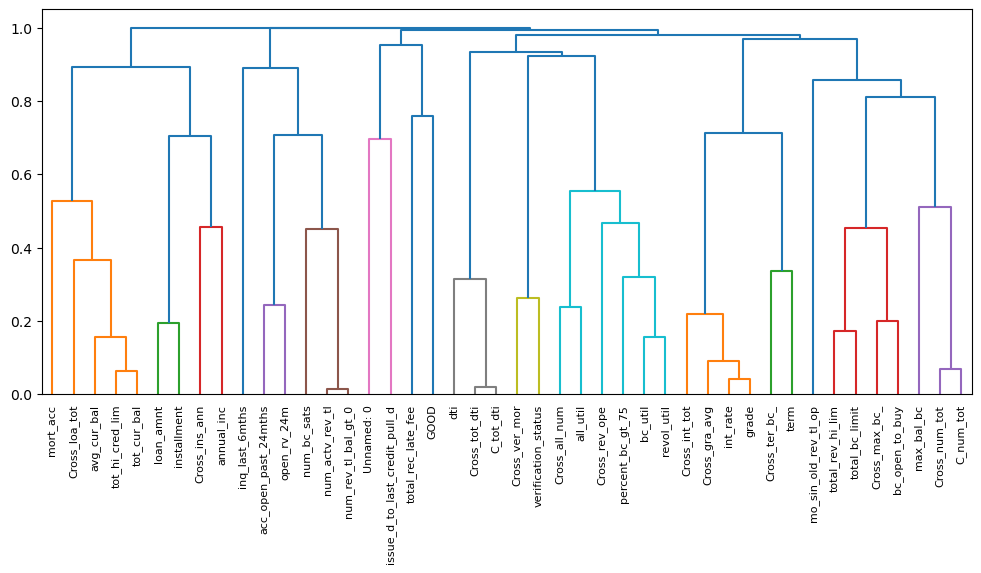

In [22]:
correlations = df.corr()
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(correlations)
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=df.columns, orientation='top', 
           leaf_rotation=90);


In [21]:
df[['loan_amnt', 'installment']].corr()

,loan_amnt,installment
loan_amnt,1.000000,0.805032
installment,0.805032,1.000000


In [3]:
# Clusterize the data
threshold = 0.8
labels = fcluster(Z, threshold, criterion='distance')

# Show the cluster
labels

array([ 5,  1, 10, 10,  2, 10,  8,  7,  9, 11,  9, 12,  2, 10, 10,  2, 10,
        8,  2,  7,  3, 11,  9,  1,  3,  3,  9,  3,  9,  4,  9, 11, 13,  1,
       11,  6,  5, 12,  3,  1,  1, 12,  7,  6], dtype=int32)

In [5]:
import numpy as np

# Keep the indices to sort labels
labels_order = np.argsort(labels)

# Build a new dataframe with the sorted columns
for idx, i in enumerate(df.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(df[i])
    else:
        df_to_append = pd.DataFrame(df[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

In [7]:
import seaborn as sns

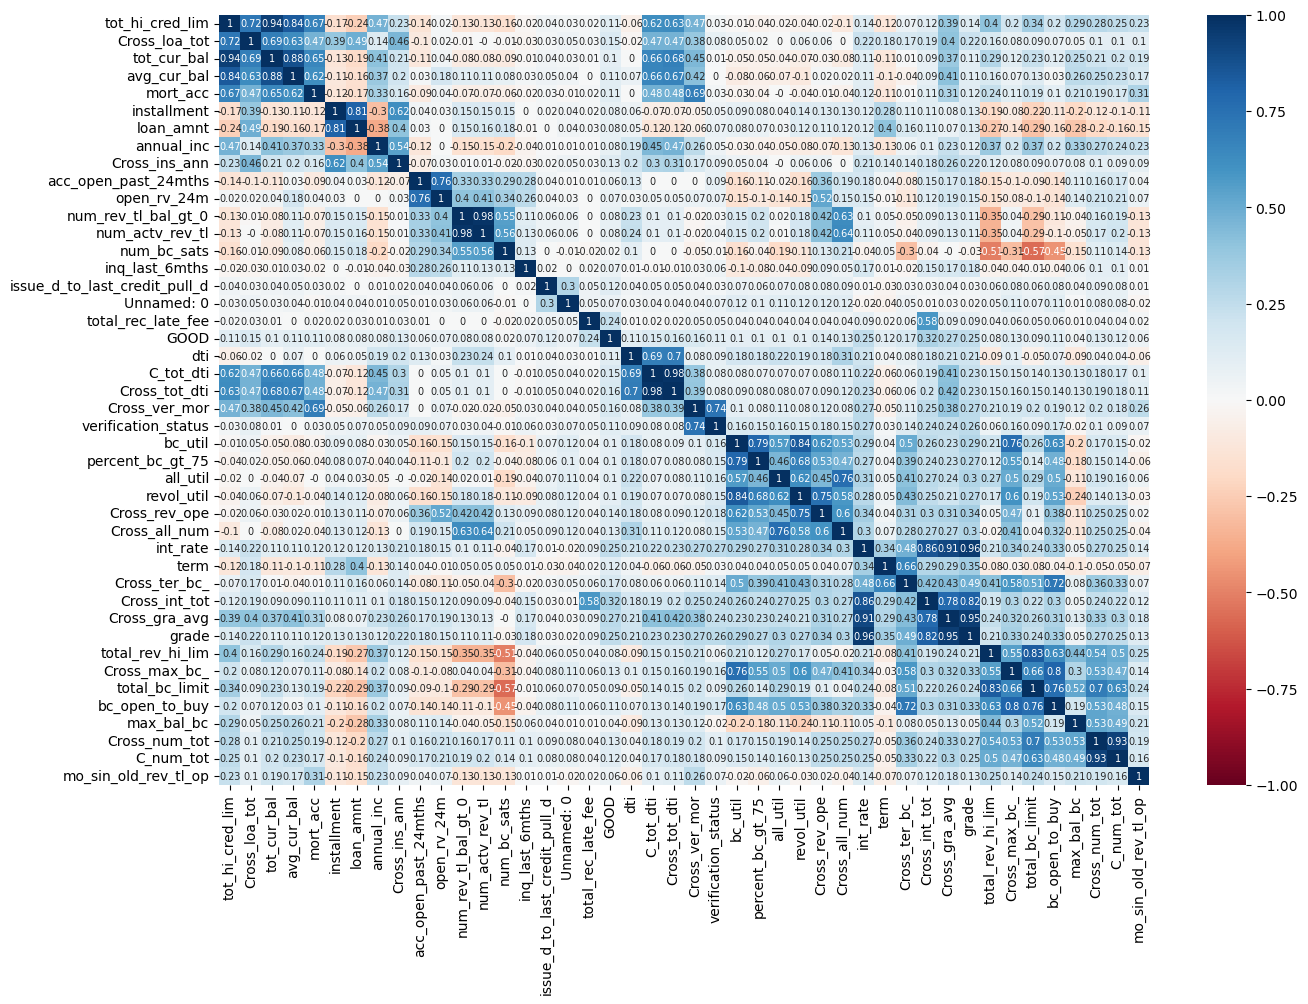

In [8]:
plt.figure(figsize=(15,10))
correlations = clustered.corr()
sns.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=-1, vmax=1);

In [ ]:
plt.figure(figsize=(15,10))

for idx, t in enumerate(np.arange(0.2,1.1,0.1)):
    
    # Subplot idx + 1
    plt.subplot(3, 3, idx+1)
    
    # Calculate the cluster
    labels = fcluster(Z, t, criterion='distance')

    # Keep the indices to sort labels
    labels_order = np.argsort(labels)

    # Build a new dataframe with the sorted columns
    for idx, i in enumerate(df.columns[labels_order]):
        if idx == 0:
            clustered = pd.DataFrame(df[i])
        else:
            df_to_append = pd.DataFrame(df[i])
            clustered = pd.concat([clustered, df_to_append], axis=1)
            
    # Plot the correlation heatmap
    correlations = clustered.corr()
    sns.heatmap(round(correlations,2), cmap='RdBu', vmin=-1, vmax=1, 
                xticklabels=False, yticklabels=False)
    plt.title("Threshold = {}".format(round(t,2)))


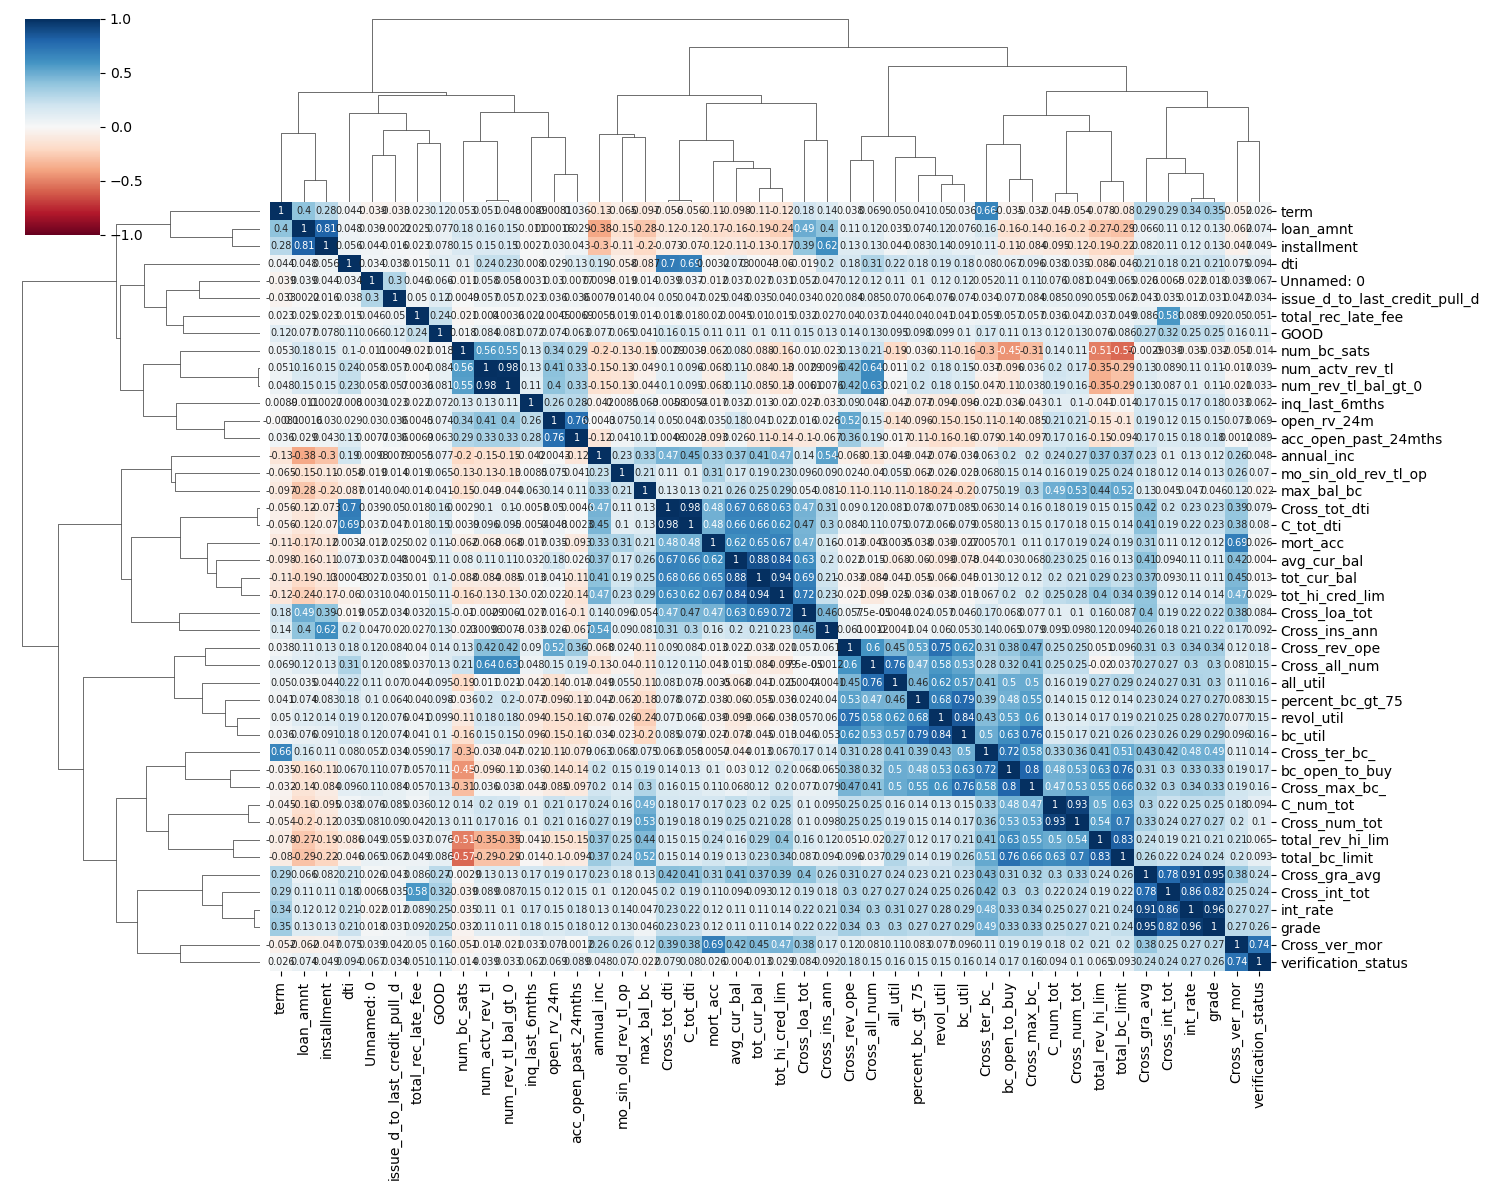

In [11]:
sns.clustermap(correlations, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12));

In [12]:
a = '''loan_amnt
term
int_rate
installment






grade

verification_status
annual_inc
dti




acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
mort_acc


num_actv_rev_tl





num_rev_tl_bal_gt_0


percent_bc_gt_75









open_rv_24m

all_util






inq_last_6mths


revol_util


total_rev_hi_lim


mo_sin_old_rev_tl_op








tot_hi_cred_lim

total_bc_limit

total_rec_late_fee
'''

b = a.split()

In [16]:
correlations = df[b].corr()

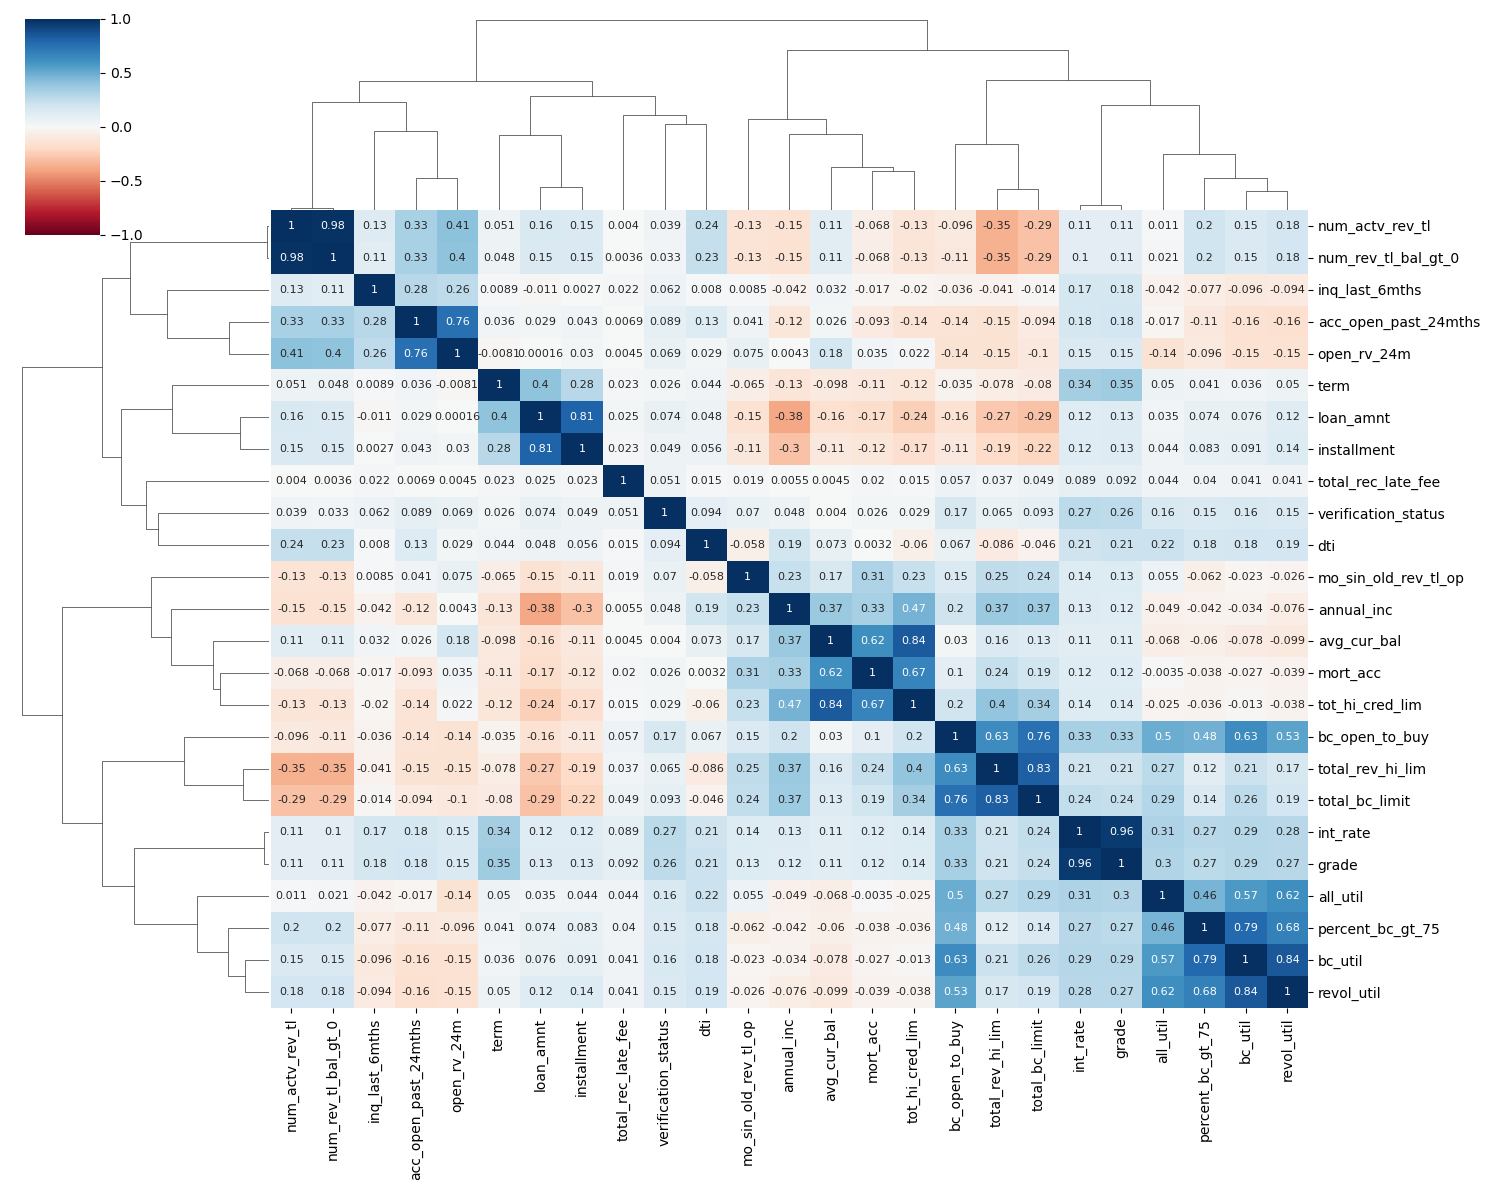

In [18]:
sns.clustermap(correlations, method="complete", cmap='RdBu', annot=True, 
               annot_kws={"size": 8}, vmin=-1, vmax=1, figsize=(15,12));

In [80]:
def cluster_correlation(data, threshold):
    from scipy.cluster.hierarchy import linkage,  fcluster
    from scipy.spatial.distance import squareform
    import numpy as np
    correlations = data.corr()
    dissimilarity = 1 - abs(correlations)
    Z = linkage(squareform(dissimilarity), 'complete')
    labels = fcluster(Z, threshold, criterion= 'distance')
    max_labels = max(labels)
    cols = data.columns
    N = len(cols)
    a = {}
    for i in range(1, max_labels+1):
        a[i] = []
    for i in range(N):
        cols_temp = cols[i]
        index_temp = labels[i]
        a[index_temp].append(cols_temp)
    for i in range(1, max_labels+1):
        if len(a[i])<2:
            a.pop(i)
        else:
            correlation_matrix = data[a[i]].corr()
            correlation_matrix_no_ones = np.where(correlation_matrix == 1, np.nan, correlation_matrix)
            max_value = np.nanmax(correlation_matrix_no_ones)
            if max_value < threshold - 0.1:
                a.pop(i)

    B = {i: v for i, v in enumerate(a.values())}   
    return B

In [81]:
n = cluster_correlation(df, 0.7)

In [82]:
n

{0: ['Cross_loa_tot',
  'mort_acc',
  'tot_hi_cred_lim',
  'avg_cur_bal',
  'tot_cur_bal'],
 1: ['loan_amnt', 'installment'],
 2: ['acc_open_past_24mths', 'open_rv_24m'],
 3: ['num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'num_bc_sats'],
 4: ['Cross_tot_dti', 'dti', 'C_tot_dti'],
 5: ['Cross_ver_mor', 'verification_status'],
 6: ['Cross_rev_ope',
  'Cross_all_num',
  'bc_util',
  'percent_bc_gt_75',
  'all_util',
  'revol_util'],
 7: ['Cross_int_tot', 'Cross_gra_avg', 'int_rate', 'grade'],
 8: ['Cross_ter_bc_', 'term'],
 9: ['Cross_max_bc_', 'bc_open_to_buy', 'total_rev_hi_lim', 'total_bc_limit'],
 10: ['Cross_num_tot', 'max_bal_bc', 'C_num_tot']}

In [88]:
df[['num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'num_bc_sats']].corr()

,num_actv_rev_tl,num_rev_tl_bal_gt_0,num_bc_sats
num_actv_rev_tl,1.000000,0.984879,0.561177
num_rev_tl_bal_gt_0,0.984879,1.000000,0.548665
num_bc_sats,0.561177,0.548665,1.000000
